In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import os
import time
import math
import numpy as np
import skimage.io as io
from torchsummary import summary

from di_dataset2 import DepthImageDataset, collate_batch

2022-03-07 18:00:53.389014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [3]:
latent_dim = 64
num_epochs = 250
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False

# Load Dataset

In [4]:
tfrecord_folder='../../../rl_data/tfrecord'
tfrecord_test_folder='../../../rl_data/tfrecord/test'

In [5]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size) # 176 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size) # 20 tfrecords

Loading tfrecords... 	['../../../rl_data/tfrecord/data163.tfrecords']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-07 18:00:54.137601: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-07 18:00:54.138349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-07 18:00:54.139987: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-07 18:00:54.140004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-07 18:00:54.140189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

Iterating length... 	Done: 69
Loading tfrecords... 	['../../../rl_data/tfrecord/test/data193.tfrecords']
Iterating length... 	Done: 58


In [6]:
len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)

69 58


2208

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

In [8]:
dataiter = iter(train_loader)
image_batch, *_ = dataiter.next() # image, height, width, depth
image_batch.shape

gotcha


torch.Size([32, 1, 270, 480])

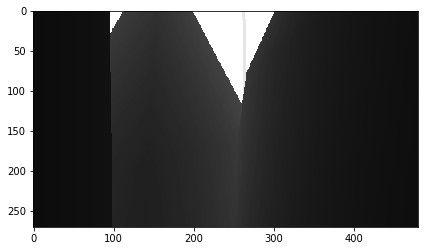

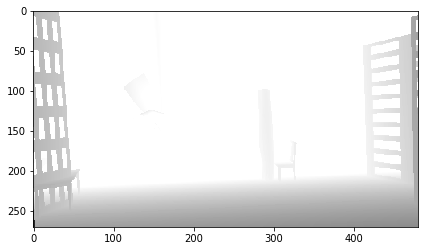

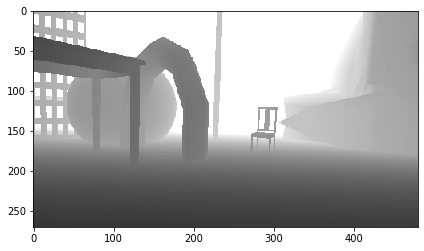

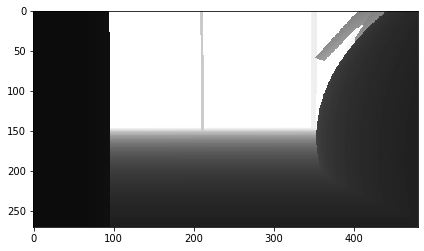

torch.Size([1, 270, 480])

In [9]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

for image in image_batch[0:4]:
    imshow(image)
    
image.shape

In [10]:
image_batch.squeeze().mean(), image_batch.squeeze().var()

(tensor(0.4794), tensor(0.1271))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [11]:
image_batch, *_ = dataiter.next()

In [12]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs, include_top=True):
        super(Dronet, self).__init__()
        self.include_top = include_top
        
        print('[Dronet] Starting dronet')

        self.max0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # default pool_size='2', strides=2

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) # padding='same' 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 64) # Todo: check size
        self.dense1 = nn.Linear(64, 32)
        self.dense2 = nn.Linear(32, num_outputs)
        self.dense3 = nn.Linear(9*15*128, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        #print(img.shape)
        #print(f"- Before encoding, mean: {img.mean():.3f} var: {img.var():.3f}")
        x1 = self.conv0(img)
        #print("x1:", x1.shape)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)
        #print("x1:", x1.shape)

        # First residual block
        x2 = self.bn0(x1)
        #print("x2:", x2.shape)
        # x2 = x1
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv1(x2)
        #print(x2.shape)

        x2 = self.bn1(x2)
        #print(x2.shape)
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv2(x2)
        #print(x2.shape)
        
        
        x1 = self.conv3(x1)
        #print(f"x1: {x1.shape}, x2: {x2.shape}") # 32, 34, 60
        x3 = x1+x2
        #print("x3:", x3.shape)

        # Second residual block
        x4 = self.bn2(x3)
        #print("x4:", x4.shape)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)
        #print(x4.shape)

        x4 = self.bn3(x4)
        #print(x4.shape)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        #print(x4.shape)
        
        x3 = self.conv6(x3)
        #print(f"x3: {x3.shape}, x4: {x4.shape}")
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        # x6 = x5
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        #print(f"x5: {x5.shape}, x6: {x6.shape}")
        x7 = x5+x6 # 17, 30, 128

        x = x7.view(x7.size(0), -1)
        #print(f"x before linear: {x.shape}")
        #print(f"- After encoding, mean: {x.mean():.3f} var: {x.var():.3f}")

        if self.include_top:
            x = torch.relu(x)
            # x = tf.keras.layers.Dropout(0.5)(x)
            x = self.dense0(x)
            x = self.dense1(x)
            #gate_pose = self.dense2(x)
            x_enc = self.dense2(x)
            # phi_rel = self.dense_phi_rel(x)
            # gate_pose = tf.concat([gate_pose, phi_rel], 1)
            #print(f"x_enc: {x.shape}")
            return x_enc
        else:
            x = self.dense3(x)
            #print(f"x_enc: {x.shape}")
            return x

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2, include_top=True)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

[Dronet] Starting dronet
[Dronet] Done with dronet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      BatchNorm2d-13           [-1, 64, 17, 30]     

### Decoder

In [13]:
class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        #print("z: ", z.shape)
        x = self.dense(z)
        #print(x.shape)
        x = x.view(x.size(0), 128, 9, 15)
        #print(f"- Before deconv, mean: {x.mean():.3f} var: {x.var():.3f}")
        
        x = self.deconv1(x)
        x = torch.relu(x)
        #print("after deconv1", x.shape)
        
        x = self.deconv2(x)
        x = torch.relu(x)
        #print("after deconv2", x.shape)
        
        x = self.deconv3(x)
        x = torch.relu(x)
#         print("after deconv3", x.shape)

        x = self.deconv4(x)
        x = torch.relu(x)
#         print("after deconv4", x.shape)

        x = self.deconv5(x)
        #print("indices", indices.shape)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
#       print("after deconv5", x.shape)
        x = torch.relu(x)
        #print("after unpool", x.shape)
        
        x = self.deconv6(x)
        x = torch.relu(x)
#         print("after deconv6", x.shape)

        x = self.deconv7(x)
        #print(f"- After deconv 7, mean: {x.mean():.3f} var: {x.var():.3f}")
        x = torch.sigmoid(x)
        #print(f"- After sigmoid, mean: {x.mean():.3f} var: {x.var():.3f}")
        #print("after deconv7", x.shape)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1)
summary(img_decoder, (1,latent_dim))

[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 17280]       1,123,200
   ConvTranspose2d-2           [-1, 128, 9, 15]         147,584
   ConvTranspose2d-3           [-1, 64, 17, 30]         204,864
   ConvTranspose2d-4           [-1, 64, 34, 60]         147,520
   ConvTranspose2d-5          [-1, 32, 68, 120]          73,760
   ConvTranspose2d-6         [-1, 32, 135, 240]          25,632
   ConvTranspose2d-7         [-1, 16, 270, 480]          18,448
   ConvTranspose2d-8          [-1, 1, 270, 480]             401
Total params: 1,741,409
Trainable params: 1,741,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 28.22
Params size (MB): 6.64
Estimated Total Size (MB): 34.86
------------------------------

## VAE

In [14]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=n_z*2, include_top=True)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):
        # Possible modes for reconstruction:
        # img -> img

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        # Possible modes for reconstruction:
        # z -> img
        img_recon = self.p_img(z)
        return img_recon


### Define Model

In [15]:
vae_model = VAE(n_z=latent_dim)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
else:
    vae_model.train()

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 3

# Training

In [16]:
def depth_gain(x):
    return 1/(x + 0.5) - 0.5

def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def MSE(x, x_hat, mu, logvar):
    #rep = (x_hat - x)**2
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

def weighted_MSE(x, x_hat, mu, logvar):
    reproduction_loss_ref = F.mse_loss(x_hat, x, reduction="sum")
    
    reproduction_loss = (depth_gain(x) * torch.square(x_hat - x)).sum()
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    #print(reproduction_loss, reproduction_loss_ref)
    return reproduction_loss - kl_divergence

Loading tfrecords... 	['../../../rl_data/tfrecord/data100.tfrecords']
Iterating length... 	Done: 63
gotcha
tensor(336488.6562, grad_fn=<SumBackward0>) tensor(442913.5312, grad_fn=<MseLossBackward0>)
tensor(336515.8438, grad_fn=<SubBackward0>)
tensor(378938.9688, grad_fn=<SumBackward0>) tensor(523496., grad_fn=<MseLossBackward0>)
tensor(383961.4375, grad_fn=<SubBackward0>)
tensor(354625.4375, grad_fn=<SumBackward0>) tensor(454984.6250, grad_fn=<MseLossBackward0>)
tensor(354835.5625, grad_fn=<SubBackward0>)
tensor(327252.6250, grad_fn=<SumBackward0>) tensor(496088.7500, grad_fn=<MseLossBackward0>)
tensor(327697.5938, grad_fn=<SubBackward0>)
tensor(156023.9375, grad_fn=<SumBackward0>) tensor(620768.1875, grad_fn=<MseLossBackward0>)
tensor(273285.4688, grad_fn=<SubBackward0>)
Epoch: 1/250, Step: 5/63, Avg loss: 10476.850, time: 21.62, Avg. per iter 4.22, Est. time left 244.49

tensor(206489.1250, grad_fn=<SumBackward0>) tensor(429005.6562, grad_fn=<MseLossBackward0>)
tensor(207017.2656, gr

tensor(78163.5469, grad_fn=<SumBackward0>) tensor(313228.0938, grad_fn=<MseLossBackward0>)
tensor(80617.3594, grad_fn=<SubBackward0>)
tensor(73406.7422, grad_fn=<SumBackward0>) tensor(262001.1562, grad_fn=<MseLossBackward0>)
tensor(75540.2656, grad_fn=<SubBackward0>)
Epoch: 1/250, Step: 55/63, Avg loss: 4279.352, time: 237.52, Avg. per iter 4.31, Est. time left 34.46

tensor(75030.7109, grad_fn=<SumBackward0>) tensor(248485.4375, grad_fn=<MseLossBackward0>)
tensor(77403.8750, grad_fn=<SubBackward0>)
tensor(92930.4062, grad_fn=<SumBackward0>) tensor(382171.0312, grad_fn=<MseLossBackward0>)
tensor(95983.7812, grad_fn=<SubBackward0>)
tensor(72477.1328, grad_fn=<SumBackward0>) tensor(191038.6250, grad_fn=<MseLossBackward0>)
tensor(74999.6484, grad_fn=<SubBackward0>)
tensor(92958.3281, grad_fn=<SumBackward0>) tensor(388164.7500, grad_fn=<MseLossBackward0>)
tensor(95733.3906, grad_fn=<SubBackward0>)
tensor(66725.8672, grad_fn=<SumBackward0>) tensor(242444.9531, grad_fn=<MseLossBackward0>)
te

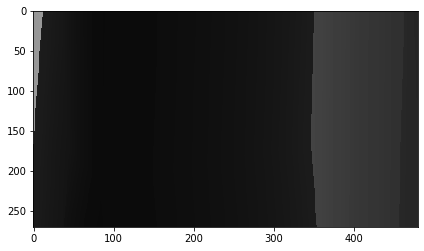

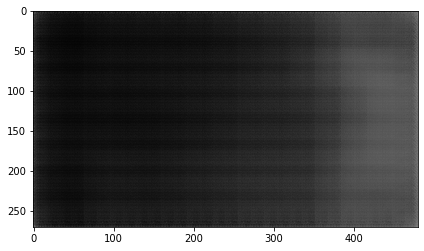

tensor(59488.4844, grad_fn=<SumBackward0>) tensor(232383.7188, grad_fn=<MseLossBackward0>)
tensor(61842.3438, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data113.tfrecords']
Iterating length... 	Done: 60
gotcha
tensor(74038.1719, grad_fn=<SumBackward0>) tensor(276374.8750, grad_fn=<MseLossBackward0>)
tensor(76920.1641, grad_fn=<SubBackward0>)
tensor(62535.0742, grad_fn=<SumBackward0>) tensor(184845.0625, grad_fn=<MseLossBackward0>)
tensor(65216.2383, grad_fn=<SubBackward0>)
tensor(93955.8281, grad_fn=<SumBackward0>) tensor(397078.0625, grad_fn=<MseLossBackward0>)
tensor(97134.1094, grad_fn=<SubBackward0>)
tensor(73007.9688, grad_fn=<SumBackward0>) tensor(315871.7812, grad_fn=<MseLossBackward0>)
tensor(75643.5234, grad_fn=<SubBackward0>)
tensor(72850.1484, grad_fn=<SumBackward0>) tensor(259850.1719, grad_fn=<MseLossBackward0>)
tensor(75150.0156, grad_fn=<SubBackward0>)
Epoch: 2/250, Step: 5/60, Avg loss: 2437.900, time: 21.64, Avg. per iter 4.31, Est. time 

tensor(66697.3984, grad_fn=<SumBackward0>) tensor(263290.0312, grad_fn=<MseLossBackward0>)
tensor(69171.6953, grad_fn=<SubBackward0>)
tensor(90535.8281, grad_fn=<SumBackward0>) tensor(325275.0312, grad_fn=<MseLossBackward0>)
tensor(93199.0938, grad_fn=<SubBackward0>)
tensor(102001.9375, grad_fn=<SumBackward0>) tensor(420027., grad_fn=<MseLossBackward0>)
tensor(104799.5469, grad_fn=<SubBackward0>)
Epoch: 2/250, Step: 55/60, Avg loss: 2435.962, time: 238.39, Avg. per iter 4.32, Est. time left 21.60

tensor(80788.5938, grad_fn=<SumBackward0>) tensor(332426.1875, grad_fn=<MseLossBackward0>)
tensor(83247.1016, grad_fn=<SubBackward0>)
tensor(86628.6406, grad_fn=<SumBackward0>) tensor(241218.9062, grad_fn=<MseLossBackward0>)
tensor(88863.2031, grad_fn=<SubBackward0>)
tensor(85089.4844, grad_fn=<SumBackward0>) tensor(321938.1562, grad_fn=<MseLossBackward0>)
tensor(87442.4297, grad_fn=<SubBackward0>)
tensor(92512.8906, grad_fn=<SumBackward0>) tensor(234327.5625, grad_fn=<MseLossBackward0>)
tens

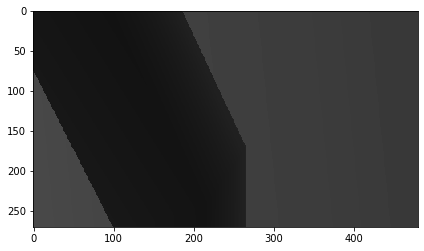

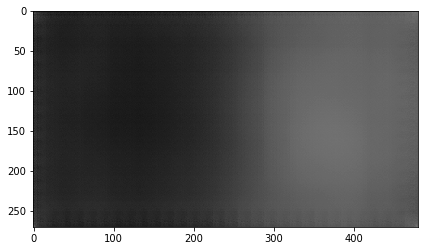

tensor(28184.8789, grad_fn=<SumBackward0>) tensor(108378.3984, grad_fn=<MseLossBackward0>)
tensor(29722.1289, grad_fn=<SubBackward0>)
Epoch: 2/250, Step: 60/60, Avg loss: 2432.897, time: 257.53, Avg. per iter 4.30, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data9.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(87199.6406, grad_fn=<SumBackward0>) tensor(357258.6250, grad_fn=<MseLossBackward0>)
tensor(90798.8906, grad_fn=<SubBackward0>)
tensor(83712.5547, grad_fn=<SumBackward0>) tensor(301820.3125, grad_fn=<MseLossBackward0>)
tensor(87369.6875, grad_fn=<SubBackward0>)
tensor(77162.6250, grad_fn=<SumBackward0>) tensor(233079.4844, grad_fn=<MseLossBackward0>)
tensor(80738.9453, grad_fn=<SubBackward0>)
tensor(89263.4375, grad_fn=<SumBackward0>) tensor(369493.6875, grad_fn=<MseLossBackward0>)
tensor(93218.4766, grad_fn=<SubBackward0>)
tensor(61673.8516, grad_fn=<SumBackward0>) tensor(223168.3438, grad_fn=<MseLossBackward0>)
tensor(64734.9453, grad_fn=<SubB

tensor(60854.0156, grad_fn=<SumBackward0>) tensor(239151.0938, grad_fn=<MseLossBackward0>)
tensor(63351.9219, grad_fn=<SubBackward0>)
tensor(70932.1328, grad_fn=<SumBackward0>) tensor(269459.5938, grad_fn=<MseLossBackward0>)
tensor(73668.9609, grad_fn=<SubBackward0>)
tensor(57547.0859, grad_fn=<SumBackward0>) tensor(261022.4062, grad_fn=<MseLossBackward0>)
tensor(60289.9727, grad_fn=<SubBackward0>)
tensor(58961.1562, grad_fn=<SumBackward0>) tensor(234496.4062, grad_fn=<MseLossBackward0>)
tensor(61599.5469, grad_fn=<SubBackward0>)
Epoch: 3/250, Step: 55/61, Avg loss: 2235.048, time: 230.55, Avg. per iter 4.26, Est. time left 25.57

tensor(65243.4062, grad_fn=<SumBackward0>) tensor(285408.0625, grad_fn=<MseLossBackward0>)
tensor(67932.3906, grad_fn=<SubBackward0>)
tensor(55855.4961, grad_fn=<SumBackward0>) tensor(232030.2031, grad_fn=<MseLossBackward0>)
tensor(58405.5938, grad_fn=<SubBackward0>)
tensor(62688.5391, grad_fn=<SumBackward0>) tensor(270762.6250, grad_fn=<MseLossBackward0>)
te

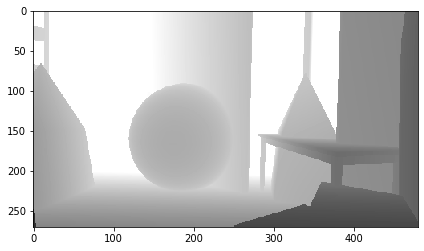

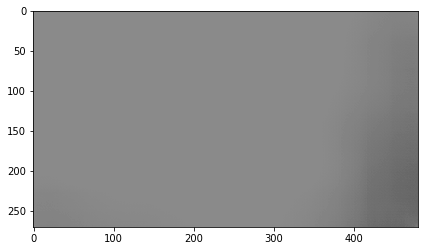

tensor(46962.4102, grad_fn=<SumBackward0>) tensor(217898.6875, grad_fn=<MseLossBackward0>)
tensor(48376.1523, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data147.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(64317.2969, grad_fn=<SumBackward0>) tensor(262464.4688, grad_fn=<MseLossBackward0>)
tensor(66324.8672, grad_fn=<SubBackward0>)
tensor(56259.3945, grad_fn=<SumBackward0>) tensor(246674.3125, grad_fn=<MseLossBackward0>)
tensor(58458.2305, grad_fn=<SubBackward0>)
tensor(61810.0234, grad_fn=<SumBackward0>) tensor(252823.2031, grad_fn=<MseLossBackward0>)
tensor(63964.2188, grad_fn=<SubBackward0>)
tensor(51688.0312, grad_fn=<SumBackward0>) tensor(184584.4219, grad_fn=<MseLossBackward0>)
tensor(53907.5547, grad_fn=<SubBackward0>)
tensor(45730.0391, grad_fn=<SumBackward0>) tensor(189608.8750, grad_fn=<MseLossBackward0>)
tensor(47890.4219, grad_fn=<SubBackward0>)
Epoch: 4/250, Step: 5/64, Avg loss: 1815.908, time: 20.76, Avg. per iter 4.25, Est. time 

tensor(43166.5430, grad_fn=<SumBackward0>) tensor(151872.5625, grad_fn=<MseLossBackward0>)
tensor(46128.2891, grad_fn=<SubBackward0>)
tensor(38076.4414, grad_fn=<SumBackward0>) tensor(126375.1484, grad_fn=<MseLossBackward0>)
tensor(41214.1328, grad_fn=<SubBackward0>)
tensor(32071.4492, grad_fn=<SumBackward0>) tensor(79341.7188, grad_fn=<MseLossBackward0>)
tensor(35195.1758, grad_fn=<SubBackward0>)
Epoch: 4/250, Step: 55/64, Avg loss: 1912.939, time: 242.39, Avg. per iter 4.29, Est. time left 38.58

tensor(46109.5469, grad_fn=<SumBackward0>) tensor(141155.8750, grad_fn=<MseLossBackward0>)
tensor(50096.4492, grad_fn=<SubBackward0>)
tensor(51800.6250, grad_fn=<SumBackward0>) tensor(175765.9531, grad_fn=<MseLossBackward0>)
tensor(55773.2773, grad_fn=<SubBackward0>)
tensor(41708.6055, grad_fn=<SumBackward0>) tensor(134455., grad_fn=<MseLossBackward0>)
tensor(45574.7383, grad_fn=<SubBackward0>)
tensor(39817.6328, grad_fn=<SumBackward0>) tensor(119133.3047, grad_fn=<MseLossBackward0>)
tensor(

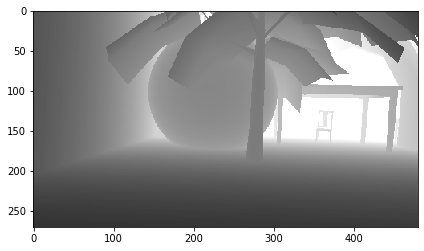

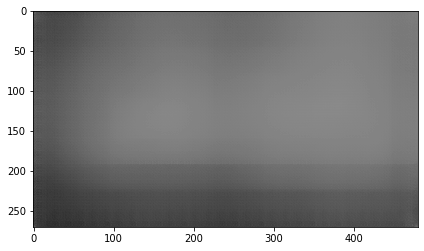

tensor(22033.4648, grad_fn=<SumBackward0>) tensor(77055.5703, grad_fn=<MseLossBackward0>)
tensor(23630.2383, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data31.tfrecords']
Iterating length... 	Done: 67
gotcha
tensor(46382.5430, grad_fn=<SumBackward0>) tensor(167159.8125, grad_fn=<MseLossBackward0>)
tensor(49401.1172, grad_fn=<SubBackward0>)
tensor(47857.5391, grad_fn=<SumBackward0>) tensor(129950.4219, grad_fn=<MseLossBackward0>)
tensor(51032.7422, grad_fn=<SubBackward0>)
tensor(43483.6406, grad_fn=<SumBackward0>) tensor(100350.6797, grad_fn=<MseLossBackward0>)
tensor(46899.4336, grad_fn=<SubBackward0>)
tensor(40143.7227, grad_fn=<SumBackward0>) tensor(132352.5469, grad_fn=<MseLossBackward0>)
tensor(43426.6250, grad_fn=<SubBackward0>)
tensor(54878.2734, grad_fn=<SumBackward0>) tensor(187561.2188, grad_fn=<MseLossBackward0>)
tensor(58262.1094, grad_fn=<SubBackward0>)
Epoch: 5/250, Step: 5/67, Avg loss: 1556.388, time: 21.99, Avg. per iter 4.28, Est. time le

tensor(42246.5391, grad_fn=<SumBackward0>) tensor(110280.0938, grad_fn=<MseLossBackward0>)
tensor(45641.4961, grad_fn=<SubBackward0>)
tensor(37466.4844, grad_fn=<SumBackward0>) tensor(110966.9844, grad_fn=<MseLossBackward0>)
tensor(41018.6758, grad_fn=<SubBackward0>)
tensor(38154.2305, grad_fn=<SumBackward0>) tensor(119317.8281, grad_fn=<MseLossBackward0>)
tensor(41932.9688, grad_fn=<SubBackward0>)
Epoch: 5/250, Step: 55/67, Avg loss: 1424.061, time: 237.61, Avg. per iter 4.29, Est. time left 51.47

tensor(34871.7305, grad_fn=<SumBackward0>) tensor(102769.4844, grad_fn=<MseLossBackward0>)
tensor(38557.7695, grad_fn=<SubBackward0>)
tensor(31995.7227, grad_fn=<SumBackward0>) tensor(106091.4141, grad_fn=<MseLossBackward0>)
tensor(35280.9570, grad_fn=<SubBackward0>)
tensor(36629.2617, grad_fn=<SumBackward0>) tensor(119243.7812, grad_fn=<MseLossBackward0>)
tensor(39879.4414, grad_fn=<SubBackward0>)
tensor(34279.8789, grad_fn=<SumBackward0>) tensor(110968.0547, grad_fn=<MseLossBackward0>)
te

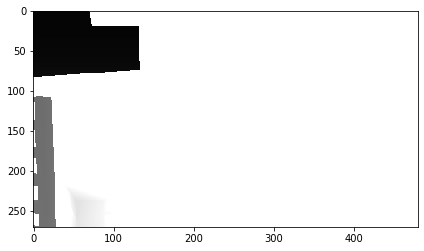

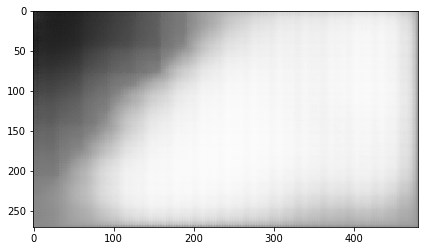

tensor(28259.5469, grad_fn=<SumBackward0>) tensor(89953.1406, grad_fn=<MseLossBackward0>)
tensor(30493.2051, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data43.tfrecords']
Iterating length... 	Done: 73
gotcha
tensor(32972.5234, grad_fn=<SumBackward0>) tensor(102858.7500, grad_fn=<MseLossBackward0>)
tensor(36139.2891, grad_fn=<SubBackward0>)
tensor(28116.2266, grad_fn=<SumBackward0>) tensor(96444.0781, grad_fn=<MseLossBackward0>)
tensor(31052.7695, grad_fn=<SubBackward0>)
tensor(35368.5586, grad_fn=<SumBackward0>) tensor(135847.3438, grad_fn=<MseLossBackward0>)
tensor(38442.1992, grad_fn=<SubBackward0>)
tensor(25217.9297, grad_fn=<SumBackward0>) tensor(82059.6172, grad_fn=<MseLossBackward0>)
tensor(28313.7656, grad_fn=<SubBackward0>)
tensor(31017.5645, grad_fn=<SumBackward0>) tensor(85705.1250, grad_fn=<MseLossBackward0>)
tensor(34176.9844, grad_fn=<SubBackward0>)
Epoch: 6/250, Step: 5/73, Avg loss: 1050.781, time: 22.87, Avg. per iter 4.29, Est. time left 

tensor(41898.3984, grad_fn=<SumBackward0>) tensor(115508.2578, grad_fn=<MseLossBackward0>)
tensor(45140.2227, grad_fn=<SubBackward0>)
tensor(47534.2891, grad_fn=<SumBackward0>) tensor(132457.4688, grad_fn=<MseLossBackward0>)
tensor(51055.9258, grad_fn=<SubBackward0>)
tensor(34120.1562, grad_fn=<SumBackward0>) tensor(81177.2031, grad_fn=<MseLossBackward0>)
tensor(37806.5352, grad_fn=<SubBackward0>)
Epoch: 6/250, Step: 55/73, Avg loss: 1222.161, time: 238.85, Avg. per iter 4.29, Est. time left 77.30

tensor(27767.0625, grad_fn=<SumBackward0>) tensor(80093.4688, grad_fn=<MseLossBackward0>)
tensor(30958.8945, grad_fn=<SubBackward0>)
tensor(28868.8809, grad_fn=<SumBackward0>) tensor(70025.3750, grad_fn=<MseLossBackward0>)
tensor(32046.2969, grad_fn=<SubBackward0>)
tensor(36614.0508, grad_fn=<SumBackward0>) tensor(101190.0859, grad_fn=<MseLossBackward0>)
tensor(39610.9844, grad_fn=<SubBackward0>)
tensor(34541.7383, grad_fn=<SumBackward0>) tensor(119633.1094, grad_fn=<MseLossBackward0>)
tenso

/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


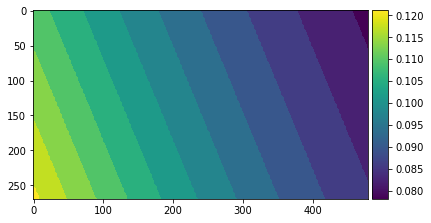

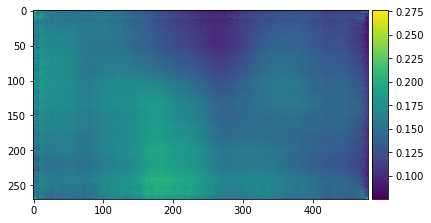

tensor(24518.5039, grad_fn=<SumBackward0>) tensor(49448.5859, grad_fn=<MseLossBackward0>)
tensor(26136.4609, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data56.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(42608.7500, grad_fn=<SumBackward0>) tensor(90397.7578, grad_fn=<MseLossBackward0>)
tensor(46400.4375, grad_fn=<SubBackward0>)
tensor(36532.1797, grad_fn=<SumBackward0>) tensor(110406.7344, grad_fn=<MseLossBackward0>)
tensor(40560.0664, grad_fn=<SubBackward0>)
tensor(37953.8711, grad_fn=<SumBackward0>) tensor(129477.2188, grad_fn=<MseLossBackward0>)
tensor(41710.5703, grad_fn=<SubBackward0>)
tensor(34783.5977, grad_fn=<SumBackward0>) tensor(117543.0625, grad_fn=<MseLossBackward0>)
tensor(38286.7461, grad_fn=<SubBackward0>)
tensor(37704.9492, grad_fn=<SumBackward0>) tensor(81090.9062, grad_fn=<MseLossBackward0>)
tensor(40781.7656, grad_fn=<SubBackward0>)
Epoch: 7/250, Step: 5/65, Avg loss: 1298.372, time: 22.05, Avg. per iter 4.30, Est. time left

tensor(53021.0938, grad_fn=<SumBackward0>) tensor(94421.3438, grad_fn=<MseLossBackward0>)
tensor(56200.1562, grad_fn=<SubBackward0>)
tensor(26334.1211, grad_fn=<SumBackward0>) tensor(79397.1719, grad_fn=<MseLossBackward0>)
tensor(29285.7480, grad_fn=<SubBackward0>)
tensor(33173.0039, grad_fn=<SumBackward0>) tensor(109844.1953, grad_fn=<MseLossBackward0>)
tensor(36235.6992, grad_fn=<SubBackward0>)
Epoch: 7/250, Step: 55/65, Avg loss: 1243.888, time: 244.15, Avg. per iter 4.31, Est. time left 43.13

tensor(33179.2422, grad_fn=<SumBackward0>) tensor(116648.2266, grad_fn=<MseLossBackward0>)
tensor(36263.8945, grad_fn=<SubBackward0>)
tensor(41713.9492, grad_fn=<SumBackward0>) tensor(152184.2812, grad_fn=<MseLossBackward0>)
tensor(44858.8711, grad_fn=<SubBackward0>)
tensor(32518.5332, grad_fn=<SumBackward0>) tensor(92694.2500, grad_fn=<MseLossBackward0>)
tensor(35497.6602, grad_fn=<SubBackward0>)
tensor(29930.7832, grad_fn=<SumBackward0>) tensor(81631.1094, grad_fn=<MseLossBackward0>)
tensor

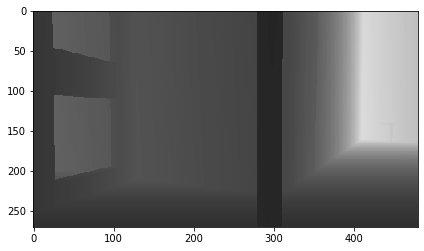

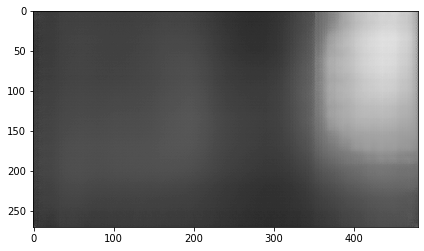

tensor(16134.1602, grad_fn=<SumBackward0>) tensor(46695.2266, grad_fn=<MseLossBackward0>)
tensor(18076.5137, grad_fn=<SubBackward0>)
Epoch: 7/250, Step: 65/65, Avg loss: 1216.331, time: 285.79, Avg. per iter 4.31, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data101.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(30461.3457, grad_fn=<SumBackward0>) tensor(94429.6250, grad_fn=<MseLossBackward0>)
tensor(33628.6406, grad_fn=<SubBackward0>)
tensor(28337.8594, grad_fn=<SumBackward0>) tensor(89845.5938, grad_fn=<MseLossBackward0>)
tensor(31669.0938, grad_fn=<SubBackward0>)
tensor(32995.1289, grad_fn=<SumBackward0>) tensor(88671.1641, grad_fn=<MseLossBackward0>)
tensor(36293.2656, grad_fn=<SubBackward0>)
tensor(30306.6602, grad_fn=<SumBackward0>) tensor(104158.5312, grad_fn=<MseLossBackward0>)
tensor(33404.9375, grad_fn=<SubBackward0>)
tensor(36010.8477, grad_fn=<SumBackward0>) tensor(124065.2734, grad_fn=<MseLossBackward0>)
tensor(38989.2695, grad_fn=<SubBac

tensor(28635.2168, grad_fn=<SumBackward0>) tensor(66047.3047, grad_fn=<MseLossBackward0>)
tensor(31607.5352, grad_fn=<SubBackward0>)
tensor(34219.3281, grad_fn=<SumBackward0>) tensor(121006.8359, grad_fn=<MseLossBackward0>)
tensor(37605.5859, grad_fn=<SubBackward0>)
tensor(40299.2656, grad_fn=<SumBackward0>) tensor(128036.3750, grad_fn=<MseLossBackward0>)
tensor(43371.0195, grad_fn=<SubBackward0>)
Epoch: 8/250, Step: 55/65, Avg loss: 1162.347, time: 241.18, Avg. per iter 4.32, Est. time left 43.16

tensor(37123.1992, grad_fn=<SumBackward0>) tensor(136986.1250, grad_fn=<MseLossBackward0>)
tensor(40121.4648, grad_fn=<SubBackward0>)
tensor(31522.7598, grad_fn=<SumBackward0>) tensor(102794.0312, grad_fn=<MseLossBackward0>)
tensor(34039.5820, grad_fn=<SubBackward0>)
tensor(47592.3438, grad_fn=<SumBackward0>) tensor(117229.4531, grad_fn=<MseLossBackward0>)
tensor(50740.1172, grad_fn=<SubBackward0>)
tensor(33520.1562, grad_fn=<SumBackward0>) tensor(86201.5547, grad_fn=<MseLossBackward0>)
tens

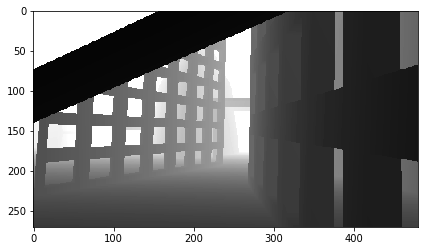

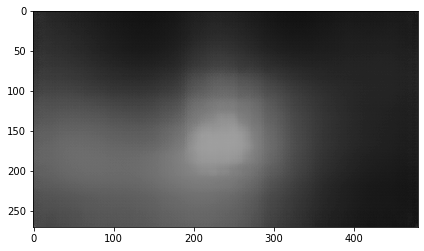

tensor(2781.0156, grad_fn=<SumBackward0>) tensor(6368.5752, grad_fn=<MseLossBackward0>)
tensor(3196.8701, grad_fn=<SubBackward0>)
Epoch: 8/250, Step: 65/65, Avg loss: 1171.571, time: 282.49, Avg. per iter 4.31, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data82.tfrecords']
Iterating length... 	Done: 68
gotcha
tensor(30993.7871, grad_fn=<SumBackward0>) tensor(82963.2812, grad_fn=<MseLossBackward0>)
tensor(34172.1719, grad_fn=<SubBackward0>)
tensor(31239.9766, grad_fn=<SumBackward0>) tensor(110582.5625, grad_fn=<MseLossBackward0>)
tensor(34108.9883, grad_fn=<SubBackward0>)
tensor(27231.9473, grad_fn=<SumBackward0>) tensor(81679.2344, grad_fn=<MseLossBackward0>)
tensor(30505.2051, grad_fn=<SubBackward0>)
tensor(28468.9980, grad_fn=<SumBackward0>) tensor(86514.6406, grad_fn=<MseLossBackward0>)
tensor(32235.0879, grad_fn=<SubBackward0>)
tensor(23917.1484, grad_fn=<SumBackward0>) tensor(81893.4297, grad_fn=<MseLossBackward0>)
tensor(27593.9727, grad_fn=<SubBackward

tensor(36308.6914, grad_fn=<SumBackward0>) tensor(84409.3594, grad_fn=<MseLossBackward0>)
tensor(39286.4336, grad_fn=<SubBackward0>)
tensor(21766.2676, grad_fn=<SumBackward0>) tensor(66623.1328, grad_fn=<MseLossBackward0>)
tensor(24637.0820, grad_fn=<SubBackward0>)
tensor(27462.0840, grad_fn=<SumBackward0>) tensor(96268.0312, grad_fn=<MseLossBackward0>)
tensor(30486.1289, grad_fn=<SubBackward0>)
Epoch: 9/250, Step: 55/68, Avg loss: 1041.324, time: 244.08, Avg. per iter 4.32, Est. time left 56.20

tensor(31485.0527, grad_fn=<SumBackward0>) tensor(107311.1172, grad_fn=<MseLossBackward0>)
tensor(34547.1133, grad_fn=<SubBackward0>)
tensor(24587.8516, grad_fn=<SumBackward0>) tensor(97900.9844, grad_fn=<MseLossBackward0>)
tensor(27290.9414, grad_fn=<SubBackward0>)
tensor(32531.2871, grad_fn=<SumBackward0>) tensor(99868.1719, grad_fn=<MseLossBackward0>)
tensor(35498.4297, grad_fn=<SubBackward0>)
tensor(36187.1680, grad_fn=<SumBackward0>) tensor(96586.0078, grad_fn=<MseLossBackward0>)
tensor(3

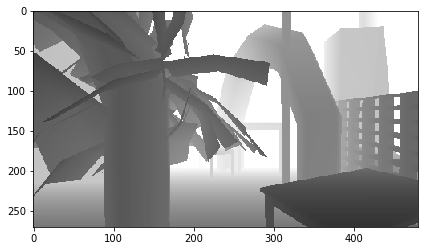

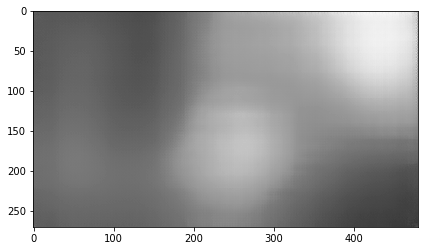

tensor(19978.6738, grad_fn=<SumBackward0>) tensor(70868.5391, grad_fn=<MseLossBackward0>)
tensor(22425.8984, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data139.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(32409.1660, grad_fn=<SumBackward0>) tensor(116519.1641, grad_fn=<MseLossBackward0>)
tensor(35378.7070, grad_fn=<SubBackward0>)
tensor(31326.3379, grad_fn=<SumBackward0>) tensor(88842.8047, grad_fn=<MseLossBackward0>)
tensor(34001.9180, grad_fn=<SubBackward0>)
tensor(32223.8066, grad_fn=<SumBackward0>) tensor(99103.0703, grad_fn=<MseLossBackward0>)
tensor(35035.6875, grad_fn=<SubBackward0>)
tensor(21680.6211, grad_fn=<SumBackward0>) tensor(83503.0469, grad_fn=<MseLossBackward0>)
tensor(24306.5605, grad_fn=<SubBackward0>)
tensor(26678.1387, grad_fn=<SumBackward0>) tensor(90881.0312, grad_fn=<MseLossBackward0>)
tensor(29278.0762, grad_fn=<SubBackward0>)
Epoch: 10/250, Step: 5/65, Avg loss: 987.506, time: 22.71, Avg. per iter 4.32, Est. time left 

tensor(25443.3711, grad_fn=<SumBackward0>) tensor(86168.5156, grad_fn=<MseLossBackward0>)
tensor(28602.3477, grad_fn=<SubBackward0>)
tensor(30755.5469, grad_fn=<SumBackward0>) tensor(106432.1484, grad_fn=<MseLossBackward0>)
tensor(33807.1523, grad_fn=<SubBackward0>)
tensor(24351.6719, grad_fn=<SumBackward0>) tensor(86103.4453, grad_fn=<MseLossBackward0>)
tensor(27104.8906, grad_fn=<SubBackward0>)
Epoch: 10/250, Step: 55/65, Avg loss: 953.973, time: 239.32, Avg. per iter 4.32, Est. time left 43.23

tensor(24708.6387, grad_fn=<SumBackward0>) tensor(88919.2109, grad_fn=<MseLossBackward0>)
tensor(27710.1094, grad_fn=<SubBackward0>)
tensor(23744.2656, grad_fn=<SumBackward0>) tensor(78133.5078, grad_fn=<MseLossBackward0>)
tensor(26521.9238, grad_fn=<SubBackward0>)
tensor(28535.8125, grad_fn=<SumBackward0>) tensor(97397.1172, grad_fn=<MseLossBackward0>)
tensor(31622.6133, grad_fn=<SubBackward0>)
tensor(33764.7227, grad_fn=<SumBackward0>) tensor(69922.7188, grad_fn=<MseLossBackward0>)
tensor(3

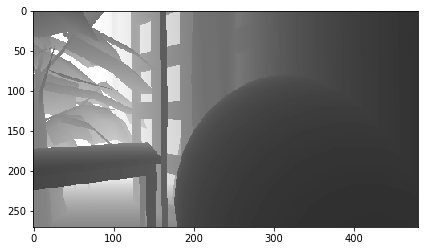

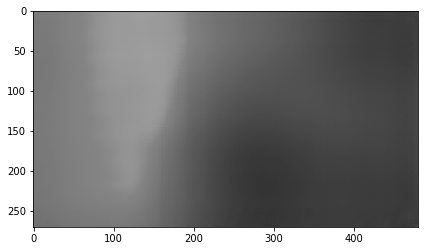

tensor(24828.5898, grad_fn=<SumBackward0>) tensor(62852.0078, grad_fn=<MseLossBackward0>)
tensor(26617.9004, grad_fn=<SubBackward0>)
Epoch: 10/250, Step: 65/65, Avg loss: 958.353, time: 281.93, Avg. per iter 4.32, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data76.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(36660.1797, grad_fn=<SumBackward0>) tensor(83662.4141, grad_fn=<MseLossBackward0>)
tensor(39436.3984, grad_fn=<SubBackward0>)
tensor(35458.2344, grad_fn=<SumBackward0>) tensor(95991.3750, grad_fn=<MseLossBackward0>)
tensor(38218.5430, grad_fn=<SubBackward0>)
tensor(29132.8105, grad_fn=<SumBackward0>) tensor(90786.0391, grad_fn=<MseLossBackward0>)
tensor(31787.5605, grad_fn=<SubBackward0>)
tensor(33949.3672, grad_fn=<SumBackward0>) tensor(107390.4531, grad_fn=<MseLossBackward0>)
tensor(36956.6953, grad_fn=<SubBackward0>)
tensor(31014.4844, grad_fn=<SumBackward0>) tensor(105967.3281, grad_fn=<MseLossBackward0>)
tensor(33755.4922, grad_fn=<SubBack

tensor(19483.9512, grad_fn=<SumBackward0>) tensor(60170.4180, grad_fn=<MseLossBackward0>)
tensor(22294.8633, grad_fn=<SubBackward0>)
tensor(22326.2051, grad_fn=<SumBackward0>) tensor(71329.6250, grad_fn=<MseLossBackward0>)
tensor(25197.0352, grad_fn=<SubBackward0>)
tensor(23242.0762, grad_fn=<SumBackward0>) tensor(66876.3672, grad_fn=<MseLossBackward0>)
tensor(25965.9062, grad_fn=<SubBackward0>)
Epoch: 11/250, Step: 55/64, Avg loss: 917.292, time: 241.37, Avg. per iter 4.33, Est. time left 38.93

tensor(23854.1973, grad_fn=<SumBackward0>) tensor(76804.4844, grad_fn=<MseLossBackward0>)
tensor(26697.1680, grad_fn=<SubBackward0>)
tensor(26827.5273, grad_fn=<SumBackward0>) tensor(79888.2891, grad_fn=<MseLossBackward0>)
tensor(29473.2500, grad_fn=<SubBackward0>)
tensor(19757.2539, grad_fn=<SumBackward0>) tensor(62508.5312, grad_fn=<MseLossBackward0>)
tensor(22394.3164, grad_fn=<SubBackward0>)
tensor(25382.3340, grad_fn=<SumBackward0>) tensor(75364.5156, grad_fn=<MseLossBackward0>)
tensor(28

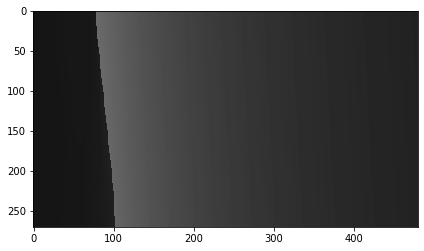

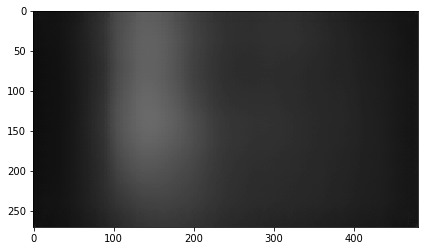

tensor(13920.9375, grad_fn=<SumBackward0>) tensor(38364.5000, grad_fn=<MseLossBackward0>)
tensor(16103.3359, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data75.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(27498.4180, grad_fn=<SumBackward0>) tensor(73802.8750, grad_fn=<MseLossBackward0>)
tensor(30350.7559, grad_fn=<SubBackward0>)
tensor(28945.8164, grad_fn=<SumBackward0>) tensor(93923.9922, grad_fn=<MseLossBackward0>)
tensor(32040.7949, grad_fn=<SubBackward0>)
tensor(29929.5273, grad_fn=<SumBackward0>) tensor(106767.3125, grad_fn=<MseLossBackward0>)
tensor(32847.6406, grad_fn=<SubBackward0>)
tensor(28108.8301, grad_fn=<SumBackward0>) tensor(95769.2500, grad_fn=<MseLossBackward0>)
tensor(31261.5781, grad_fn=<SubBackward0>)
tensor(22984.7109, grad_fn=<SumBackward0>) tensor(75216.2891, grad_fn=<MseLossBackward0>)
tensor(25764.0156, grad_fn=<SubBackward0>)
Epoch: 12/250, Step: 5/61, Avg loss: 951.655, time: 21.54, Avg. per iter 4.32, Est. time left 2

tensor(20968.4141, grad_fn=<SumBackward0>) tensor(69088.3672, grad_fn=<MseLossBackward0>)
tensor(23789.8691, grad_fn=<SubBackward0>)
tensor(28739.0156, grad_fn=<SumBackward0>) tensor(101033.5469, grad_fn=<MseLossBackward0>)
tensor(32077.8848, grad_fn=<SubBackward0>)
tensor(19917.7598, grad_fn=<SumBackward0>) tensor(64209.6367, grad_fn=<MseLossBackward0>)
tensor(22642.1348, grad_fn=<SubBackward0>)
Epoch: 12/250, Step: 55/61, Avg loss: 885.284, time: 241.97, Avg. per iter 4.33, Est. time left 25.97

tensor(29790.1641, grad_fn=<SumBackward0>) tensor(100889.4062, grad_fn=<MseLossBackward0>)
tensor(32982.1758, grad_fn=<SubBackward0>)
tensor(18293.8809, grad_fn=<SumBackward0>) tensor(51461.3672, grad_fn=<MseLossBackward0>)
tensor(21238.7617, grad_fn=<SubBackward0>)
tensor(23037.0488, grad_fn=<SumBackward0>) tensor(69161.8281, grad_fn=<MseLossBackward0>)
tensor(26057.9805, grad_fn=<SubBackward0>)
tensor(26223.0645, grad_fn=<SumBackward0>) tensor(86933.2578, grad_fn=<MseLossBackward0>)
tensor(

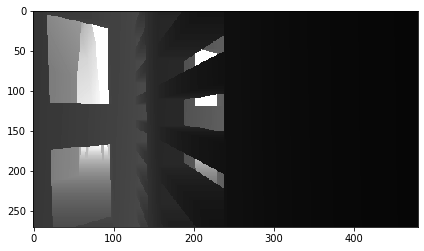

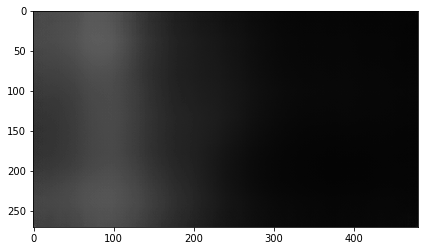

tensor(20296.5801, grad_fn=<SumBackward0>) tensor(73547.7500, grad_fn=<MseLossBackward0>)
tensor(22820.2402, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data124.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(30983.8438, grad_fn=<SumBackward0>) tensor(100476.0078, grad_fn=<MseLossBackward0>)
tensor(34066.3359, grad_fn=<SubBackward0>)
tensor(20478.4316, grad_fn=<SumBackward0>) tensor(65765.5469, grad_fn=<MseLossBackward0>)
tensor(23499.1660, grad_fn=<SubBackward0>)
tensor(24705.3398, grad_fn=<SumBackward0>) tensor(71036.8438, grad_fn=<MseLossBackward0>)
tensor(27455.5430, grad_fn=<SubBackward0>)
tensor(28902.3867, grad_fn=<SumBackward0>) tensor(98557.2266, grad_fn=<MseLossBackward0>)
tensor(31987.5117, grad_fn=<SubBackward0>)
tensor(21867.8359, grad_fn=<SumBackward0>) tensor(78432.9688, grad_fn=<MseLossBackward0>)
tensor(24671.1758, grad_fn=<SubBackward0>)
Epoch: 13/250, Step: 5/64, Avg loss: 885.498, time: 22.01, Avg. per iter 4.33, Est. time left 

tensor(23556.6719, grad_fn=<SumBackward0>) tensor(81366.3047, grad_fn=<MseLossBackward0>)
tensor(26337.2969, grad_fn=<SubBackward0>)
tensor(27186.5625, grad_fn=<SumBackward0>) tensor(90414.9453, grad_fn=<MseLossBackward0>)
tensor(29912.8164, grad_fn=<SubBackward0>)
Epoch: 13/250, Step: 55/64, Avg loss: 861.304, time: 247.09, Avg. per iter 4.34, Est. time left 39.05

tensor(23280.0508, grad_fn=<SumBackward0>) tensor(80842.3516, grad_fn=<MseLossBackward0>)
tensor(25964.2734, grad_fn=<SubBackward0>)
tensor(26728.8145, grad_fn=<SumBackward0>) tensor(98970.5156, grad_fn=<MseLossBackward0>)
tensor(29812.1562, grad_fn=<SubBackward0>)
tensor(28833.6953, grad_fn=<SumBackward0>) tensor(102118.0312, grad_fn=<MseLossBackward0>)
tensor(31650.5527, grad_fn=<SubBackward0>)
tensor(27707.0703, grad_fn=<SumBackward0>) tensor(90407.9844, grad_fn=<MseLossBackward0>)
tensor(31080.7773, grad_fn=<SubBackward0>)
tensor(26578.2910, grad_fn=<SumBackward0>) tensor(79629.2422, grad_fn=<MseLossBackward0>)
tensor(2

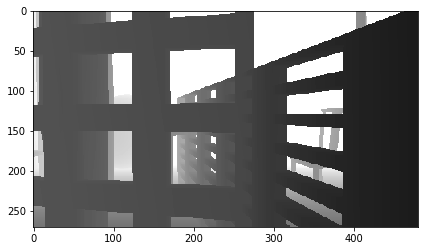

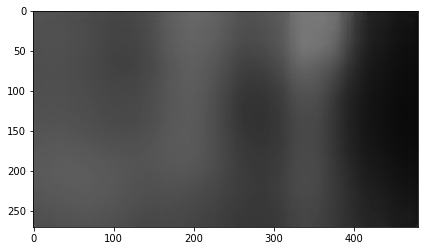

tensor(16981.6758, grad_fn=<SumBackward0>) tensor(56059.3789, grad_fn=<MseLossBackward0>)
tensor(19430.5020, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data2.tfrecords']
Iterating length... 	Done: 69
gotcha
tensor(24055.3164, grad_fn=<SumBackward0>) tensor(77852.5469, grad_fn=<MseLossBackward0>)
tensor(27079.3984, grad_fn=<SubBackward0>)
tensor(29554.2480, grad_fn=<SumBackward0>) tensor(70936.3125, grad_fn=<MseLossBackward0>)
tensor(32537.8594, grad_fn=<SubBackward0>)
tensor(28312.1094, grad_fn=<SumBackward0>) tensor(89050.0156, grad_fn=<MseLossBackward0>)
tensor(31231.4121, grad_fn=<SubBackward0>)
tensor(26421.9375, grad_fn=<SumBackward0>) tensor(84193.7891, grad_fn=<MseLossBackward0>)
tensor(29137.1035, grad_fn=<SubBackward0>)
tensor(29118.8438, grad_fn=<SumBackward0>) tensor(84612.5938, grad_fn=<MseLossBackward0>)
tensor(31705.6465, grad_fn=<SubBackward0>)
Epoch: 14/250, Step: 5/69, Avg loss: 948.071, time: 21.97, Avg. per iter 4.34, Est. time left 277

tensor(16576.3242, grad_fn=<SumBackward0>) tensor(55490.8203, grad_fn=<MseLossBackward0>)
tensor(19258.1680, grad_fn=<SubBackward0>)
tensor(21907.4980, grad_fn=<SumBackward0>) tensor(73950.3359, grad_fn=<MseLossBackward0>)
tensor(25049.5586, grad_fn=<SubBackward0>)
Epoch: 14/250, Step: 55/69, Avg loss: 843.034, time: 235.17, Avg. per iter 4.33, Est. time left 60.68

tensor(24305.4160, grad_fn=<SumBackward0>) tensor(73782.8516, grad_fn=<MseLossBackward0>)
tensor(27463.2520, grad_fn=<SubBackward0>)
tensor(25745.4902, grad_fn=<SumBackward0>) tensor(68753.0703, grad_fn=<MseLossBackward0>)
tensor(28710.3125, grad_fn=<SubBackward0>)
tensor(22622.4688, grad_fn=<SumBackward0>) tensor(71157.9531, grad_fn=<MseLossBackward0>)
tensor(25413.2715, grad_fn=<SubBackward0>)
tensor(23303.1602, grad_fn=<SumBackward0>) tensor(81659.5234, grad_fn=<MseLossBackward0>)
tensor(26048.7246, grad_fn=<SubBackward0>)
tensor(22088.5586, grad_fn=<SumBackward0>) tensor(77937.4453, grad_fn=<MseLossBackward0>)
tensor(24

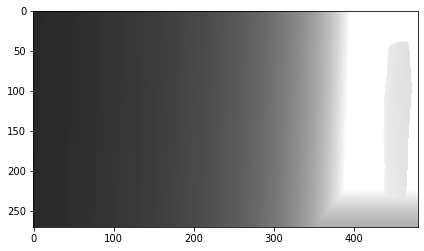

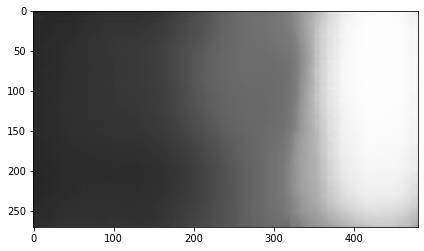

tensor(17825.4668, grad_fn=<SumBackward0>) tensor(64600.1836, grad_fn=<MseLossBackward0>)
tensor(20408.0645, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data99.tfrecords']
Iterating length... 	Done: 67
gotcha
tensor(25366.7559, grad_fn=<SumBackward0>) tensor(90750.9375, grad_fn=<MseLossBackward0>)
tensor(28242.7676, grad_fn=<SubBackward0>)
tensor(26529.5781, grad_fn=<SumBackward0>) tensor(97662.9219, grad_fn=<MseLossBackward0>)
tensor(29643.9004, grad_fn=<SubBackward0>)
tensor(20478.1172, grad_fn=<SumBackward0>) tensor(66304.1406, grad_fn=<MseLossBackward0>)
tensor(23450.7363, grad_fn=<SubBackward0>)
tensor(37243.9414, grad_fn=<SumBackward0>) tensor(83379.8906, grad_fn=<MseLossBackward0>)
tensor(40372.6758, grad_fn=<SubBackward0>)
tensor(28531.9551, grad_fn=<SumBackward0>) tensor(82686.7656, grad_fn=<MseLossBackward0>)
tensor(31516.9023, grad_fn=<SubBackward0>)
Epoch: 15/250, Step: 5/67, Avg loss: 957.669, time: 21.52, Avg. per iter 4.33, Est. time left 26

tensor(27835.6367, grad_fn=<SumBackward0>) tensor(96396.3438, grad_fn=<MseLossBackward0>)
tensor(30463.4746, grad_fn=<SubBackward0>)
tensor(27987.1465, grad_fn=<SumBackward0>) tensor(101589.5000, grad_fn=<MseLossBackward0>)
tensor(30807.3926, grad_fn=<SubBackward0>)
tensor(25984.4727, grad_fn=<SumBackward0>) tensor(83083.1328, grad_fn=<MseLossBackward0>)
tensor(28733.2383, grad_fn=<SubBackward0>)
Epoch: 15/250, Step: 55/67, Avg loss: 941.422, time: 245.87, Avg. per iter 4.34, Est. time left 52.07

tensor(27850.0312, grad_fn=<SumBackward0>) tensor(98583.7656, grad_fn=<MseLossBackward0>)
tensor(30407.6953, grad_fn=<SubBackward0>)
tensor(25568.7891, grad_fn=<SumBackward0>) tensor(84664.0938, grad_fn=<MseLossBackward0>)
tensor(28200.1738, grad_fn=<SubBackward0>)
tensor(25476.9082, grad_fn=<SumBackward0>) tensor(82298.5625, grad_fn=<MseLossBackward0>)
tensor(28152.0176, grad_fn=<SubBackward0>)
tensor(30139.3379, grad_fn=<SumBackward0>) tensor(82049.9219, grad_fn=<MseLossBackward0>)
tensor(3

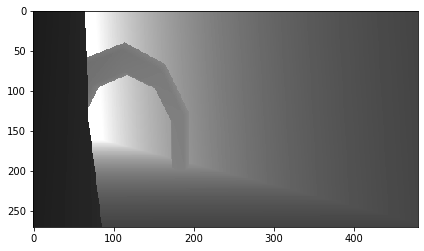

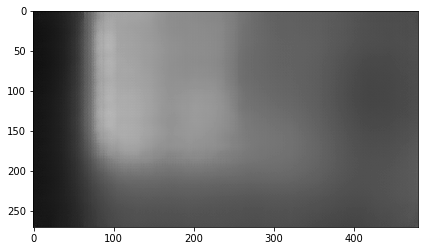

tensor(12030.2930, grad_fn=<SumBackward0>) tensor(39969.4922, grad_fn=<MseLossBackward0>)
tensor(13682.9297, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data99.tfrecords']
Iterating length... 	Done: 67
gotcha
tensor(25538.9297, grad_fn=<SumBackward0>) tensor(84822.9062, grad_fn=<MseLossBackward0>)
tensor(28203.2715, grad_fn=<SubBackward0>)
tensor(24358.8125, grad_fn=<SumBackward0>) tensor(87820.7656, grad_fn=<MseLossBackward0>)
tensor(27232.2598, grad_fn=<SubBackward0>)
tensor(25733.9492, grad_fn=<SumBackward0>) tensor(82699.6641, grad_fn=<MseLossBackward0>)
tensor(28609.6992, grad_fn=<SubBackward0>)
tensor(22923.9492, grad_fn=<SumBackward0>) tensor(84863.6719, grad_fn=<MseLossBackward0>)
tensor(25712.1406, grad_fn=<SubBackward0>)
tensor(29599.2266, grad_fn=<SumBackward0>) tensor(95857.2344, grad_fn=<MseLossBackward0>)
tensor(32393.9062, grad_fn=<SubBackward0>)
Epoch: 16/250, Step: 5/67, Avg loss: 888.445, time: 22.16, Avg. per iter 4.34, Est. time left 26

tensor(26895.0488, grad_fn=<SumBackward0>) tensor(85605.7500, grad_fn=<MseLossBackward0>)
tensor(29908.2520, grad_fn=<SubBackward0>)
tensor(25507.5234, grad_fn=<SumBackward0>) tensor(73437.0078, grad_fn=<MseLossBackward0>)
tensor(28542.1445, grad_fn=<SubBackward0>)
Epoch: 16/250, Step: 55/67, Avg loss: 859.884, time: 248.05, Avg. per iter 4.35, Est. time left 52.17

tensor(23048.3184, grad_fn=<SumBackward0>) tensor(85365.4688, grad_fn=<MseLossBackward0>)
tensor(26099.5176, grad_fn=<SubBackward0>)
tensor(24105.8418, grad_fn=<SumBackward0>) tensor(87166.8516, grad_fn=<MseLossBackward0>)
tensor(27005.0527, grad_fn=<SubBackward0>)
tensor(24567.9219, grad_fn=<SumBackward0>) tensor(82739.5547, grad_fn=<MseLossBackward0>)
tensor(27729.0391, grad_fn=<SubBackward0>)
tensor(19599.4023, grad_fn=<SumBackward0>) tensor(69705.3594, grad_fn=<MseLossBackward0>)
tensor(22623.1406, grad_fn=<SubBackward0>)
tensor(22687.5273, grad_fn=<SumBackward0>) tensor(76271.8438, grad_fn=<MseLossBackward0>)
tensor(25

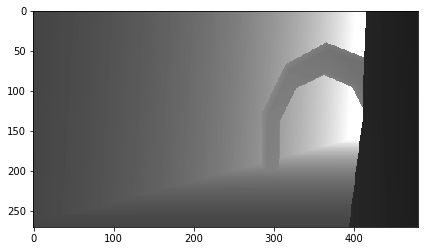

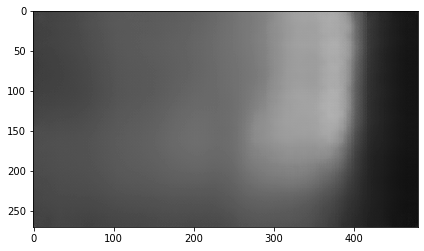

tensor(14293.8965, grad_fn=<SumBackward0>) tensor(44375.6641, grad_fn=<MseLossBackward0>)
tensor(15870.6377, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data67.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(25836.3066, grad_fn=<SumBackward0>) tensor(70082.4062, grad_fn=<MseLossBackward0>)
tensor(28766.7754, grad_fn=<SubBackward0>)
tensor(25098.2695, grad_fn=<SumBackward0>) tensor(78247.1719, grad_fn=<MseLossBackward0>)
tensor(27708.2188, grad_fn=<SubBackward0>)
tensor(27838.7207, grad_fn=<SumBackward0>) tensor(96877.6719, grad_fn=<MseLossBackward0>)
tensor(30549.5859, grad_fn=<SubBackward0>)
tensor(20151.7305, grad_fn=<SumBackward0>) tensor(80734.8906, grad_fn=<MseLossBackward0>)
tensor(22782.6719, grad_fn=<SubBackward0>)
tensor(19427.9023, grad_fn=<SumBackward0>) tensor(68557.2656, grad_fn=<MseLossBackward0>)
tensor(22153.0566, grad_fn=<SubBackward0>)
Epoch: 17/250, Step: 5/61, Avg loss: 824.752, time: 22.33, Avg. per iter 4.35, Est. time left 24

tensor(21947.6016, grad_fn=<SumBackward0>) tensor(75772.3750, grad_fn=<MseLossBackward0>)
tensor(24809.0293, grad_fn=<SubBackward0>)
tensor(27074.2969, grad_fn=<SumBackward0>) tensor(72659.2422, grad_fn=<MseLossBackward0>)
tensor(29989.9082, grad_fn=<SubBackward0>)
Epoch: 17/250, Step: 55/61, Avg loss: 797.011, time: 244.24, Avg. per iter 4.35, Est. time left 26.11

tensor(19318.9160, grad_fn=<SumBackward0>) tensor(62417.8516, grad_fn=<MseLossBackward0>)
tensor(21989.2695, grad_fn=<SubBackward0>)
tensor(23779.5234, grad_fn=<SumBackward0>) tensor(74678.0469, grad_fn=<MseLossBackward0>)
tensor(26419.1660, grad_fn=<SubBackward0>)
tensor(22249.3945, grad_fn=<SumBackward0>) tensor(75491.1484, grad_fn=<MseLossBackward0>)
tensor(25289.2246, grad_fn=<SubBackward0>)
tensor(24212.3359, grad_fn=<SumBackward0>) tensor(88808.5469, grad_fn=<MseLossBackward0>)
tensor(27345.7070, grad_fn=<SubBackward0>)
tensor(26976.8320, grad_fn=<SumBackward0>) tensor(88508.5625, grad_fn=<MseLossBackward0>)
tensor(29

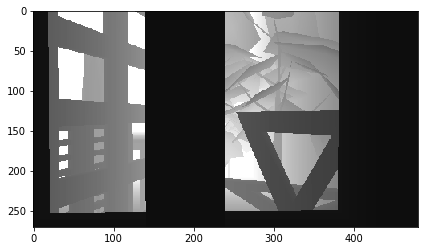

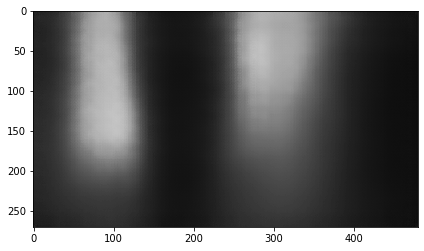

tensor(16194.7402, grad_fn=<SumBackward0>) tensor(56849.8438, grad_fn=<MseLossBackward0>)
tensor(18134.5684, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data103.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(26991.3535, grad_fn=<SumBackward0>) tensor(71321.8359, grad_fn=<MseLossBackward0>)
tensor(30039.3184, grad_fn=<SubBackward0>)
tensor(23055.7344, grad_fn=<SumBackward0>) tensor(81207.6250, grad_fn=<MseLossBackward0>)
tensor(26266.7773, grad_fn=<SubBackward0>)
tensor(24657.7754, grad_fn=<SumBackward0>) tensor(86792., grad_fn=<MseLossBackward0>)
tensor(27706.7441, grad_fn=<SubBackward0>)
tensor(21781.1035, grad_fn=<SumBackward0>) tensor(75751.6562, grad_fn=<MseLossBackward0>)
tensor(25042.7891, grad_fn=<SubBackward0>)
tensor(22700.9922, grad_fn=<SumBackward0>) tensor(70280.3984, grad_fn=<MseLossBackward0>)
tensor(25669.6074, grad_fn=<SubBackward0>)
Epoch: 18/250, Step: 5/65, Avg loss: 842.033, time: 22.28, Avg. per iter 4.35, Est. time left 261.0

tensor(24237.3652, grad_fn=<SumBackward0>) tensor(76806.7969, grad_fn=<MseLossBackward0>)
tensor(27304.4375, grad_fn=<SubBackward0>)
tensor(28438.8184, grad_fn=<SumBackward0>) tensor(92773.2500, grad_fn=<MseLossBackward0>)
tensor(31411.7559, grad_fn=<SubBackward0>)
Epoch: 18/250, Step: 55/65, Avg loss: 887.980, time: 241.86, Avg. per iter 4.35, Est. time left 43.52

tensor(22497.1016, grad_fn=<SumBackward0>) tensor(77305.4844, grad_fn=<MseLossBackward0>)
tensor(25198.1348, grad_fn=<SubBackward0>)
tensor(25648.6738, grad_fn=<SumBackward0>) tensor(94009.7500, grad_fn=<MseLossBackward0>)
tensor(28455.4141, grad_fn=<SubBackward0>)
tensor(24286.1855, grad_fn=<SumBackward0>) tensor(86009.7891, grad_fn=<MseLossBackward0>)
tensor(27315.4629, grad_fn=<SubBackward0>)
tensor(27065.2168, grad_fn=<SumBackward0>) tensor(84719.2422, grad_fn=<MseLossBackward0>)
tensor(29871.9648, grad_fn=<SubBackward0>)
tensor(18936.5898, grad_fn=<SumBackward0>) tensor(60352.8086, grad_fn=<MseLossBackward0>)
tensor(21

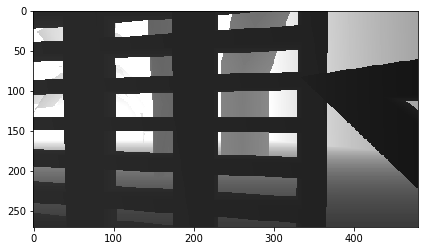

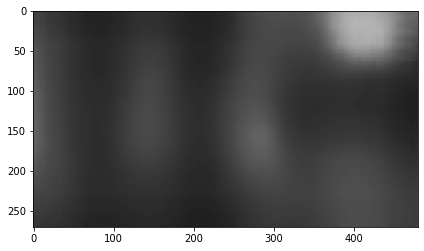

tensor(2778.8479, grad_fn=<SumBackward0>) tensor(6430.4370, grad_fn=<MseLossBackward0>)
tensor(2960.8145, grad_fn=<SubBackward0>)
Epoch: 18/250, Step: 65/65, Avg loss: 872.234, time: 284.09, Avg. per iter 4.35, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data75.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(21292.5742, grad_fn=<SumBackward0>) tensor(51387.0312, grad_fn=<MseLossBackward0>)
tensor(24121.3418, grad_fn=<SubBackward0>)
tensor(20888.5762, grad_fn=<SumBackward0>) tensor(52680.5703, grad_fn=<MseLossBackward0>)
tensor(23632.8262, grad_fn=<SubBackward0>)
tensor(30705.8320, grad_fn=<SumBackward0>) tensor(109798.7969, grad_fn=<MseLossBackward0>)
tensor(33668.5312, grad_fn=<SubBackward0>)
tensor(27946., grad_fn=<SumBackward0>) tensor(95954.1328, grad_fn=<MseLossBackward0>)
tensor(30911.2500, grad_fn=<SubBackward0>)
tensor(19565.7793, grad_fn=<SumBackward0>) tensor(66585.4688, grad_fn=<MseLossBackward0>)
tensor(22336.3320, grad_fn=<SubBackward0>)


tensor(28875.1602, grad_fn=<SumBackward0>) tensor(84036.5703, grad_fn=<MseLossBackward0>)
tensor(31849.9648, grad_fn=<SubBackward0>)
tensor(22200.2812, grad_fn=<SumBackward0>) tensor(71107.2656, grad_fn=<MseLossBackward0>)
tensor(25470.0762, grad_fn=<SubBackward0>)
tensor(28705.1133, grad_fn=<SumBackward0>) tensor(101327.3594, grad_fn=<MseLossBackward0>)
tensor(31814.4805, grad_fn=<SubBackward0>)
Epoch: 19/250, Step: 55/61, Avg loss: 793.915, time: 247.66, Avg. per iter 4.36, Est. time left 26.14

tensor(22085.0352, grad_fn=<SumBackward0>) tensor(76159.3516, grad_fn=<MseLossBackward0>)
tensor(25157.5703, grad_fn=<SubBackward0>)
tensor(17438.3711, grad_fn=<SumBackward0>) tensor(62663.1328, grad_fn=<MseLossBackward0>)
tensor(20259.1855, grad_fn=<SubBackward0>)
tensor(21647.7734, grad_fn=<SumBackward0>) tensor(64832.0977, grad_fn=<MseLossBackward0>)
tensor(24467.6836, grad_fn=<SubBackward0>)
tensor(18533.9238, grad_fn=<SumBackward0>) tensor(51805.5039, grad_fn=<MseLossBackward0>)
tensor(2

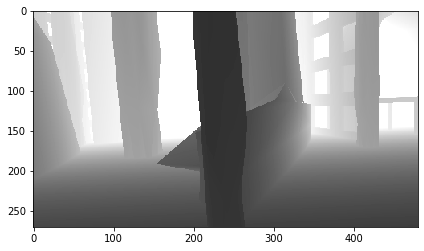

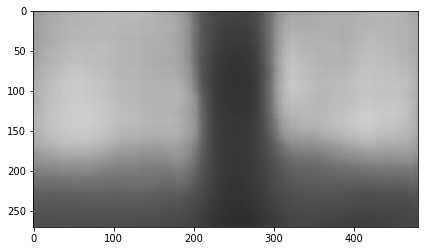

tensor(16261.8184, grad_fn=<SumBackward0>) tensor(55070.0508, grad_fn=<MseLossBackward0>)
tensor(18453.2578, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data46.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(27406.9141, grad_fn=<SumBackward0>) tensor(87426.2188, grad_fn=<MseLossBackward0>)
tensor(30082.0938, grad_fn=<SubBackward0>)
tensor(20813.6836, grad_fn=<SumBackward0>) tensor(75186.4688, grad_fn=<MseLossBackward0>)
tensor(23339.3008, grad_fn=<SubBackward0>)
tensor(25432.2246, grad_fn=<SumBackward0>) tensor(74748.1094, grad_fn=<MseLossBackward0>)
tensor(28113.8203, grad_fn=<SubBackward0>)
tensor(23232.2148, grad_fn=<SumBackward0>) tensor(71523.8047, grad_fn=<MseLossBackward0>)
tensor(25842.9551, grad_fn=<SubBackward0>)
tensor(17581.7402, grad_fn=<SumBackward0>) tensor(58119.2422, grad_fn=<MseLossBackward0>)
tensor(20309.3027, grad_fn=<SubBackward0>)
Epoch: 20/250, Step: 5/64, Avg loss: 798.047, time: 22.15, Avg. per iter 4.36, Est. time left 25

tensor(21444.6680, grad_fn=<SumBackward0>) tensor(72275.8438, grad_fn=<MseLossBackward0>)
tensor(24252.7695, grad_fn=<SubBackward0>)
tensor(20014.1211, grad_fn=<SumBackward0>) tensor(67728.5078, grad_fn=<MseLossBackward0>)
tensor(22808.0078, grad_fn=<SubBackward0>)
Epoch: 20/250, Step: 55/64, Avg loss: 768.022, time: 239.59, Avg. per iter 4.36, Est. time left 39.21

tensor(18698.6484, grad_fn=<SumBackward0>) tensor(61871.1250, grad_fn=<MseLossBackward0>)
tensor(21155.5098, grad_fn=<SubBackward0>)
tensor(21466.8125, grad_fn=<SumBackward0>) tensor(71679.0234, grad_fn=<MseLossBackward0>)
tensor(24192.1094, grad_fn=<SubBackward0>)
tensor(22345.0117, grad_fn=<SumBackward0>) tensor(74425.8203, grad_fn=<MseLossBackward0>)
tensor(25198.5098, grad_fn=<SubBackward0>)
tensor(26791.3867, grad_fn=<SumBackward0>) tensor(92841.0625, grad_fn=<MseLossBackward0>)
tensor(29780.1074, grad_fn=<SubBackward0>)
tensor(18983.2500, grad_fn=<SumBackward0>) tensor(63158.8398, grad_fn=<MseLossBackward0>)
tensor(22

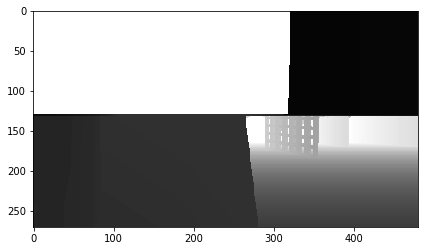

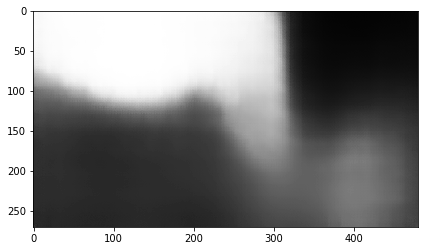

tensor(17075.3359, grad_fn=<SumBackward0>) tensor(59486.7070, grad_fn=<MseLossBackward0>)
tensor(19095.9199, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data103.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(22856.8047, grad_fn=<SumBackward0>) tensor(86683.9297, grad_fn=<MseLossBackward0>)
tensor(25765.3398, grad_fn=<SubBackward0>)
tensor(17780.4844, grad_fn=<SumBackward0>) tensor(54866.7227, grad_fn=<MseLossBackward0>)
tensor(20499.8184, grad_fn=<SubBackward0>)
tensor(28591.0449, grad_fn=<SumBackward0>) tensor(93387.6094, grad_fn=<MseLossBackward0>)
tensor(31367.7695, grad_fn=<SubBackward0>)
tensor(22058.2695, grad_fn=<SumBackward0>) tensor(73669.5156, grad_fn=<MseLossBackward0>)
tensor(25035.9121, grad_fn=<SubBackward0>)
tensor(25850.6719, grad_fn=<SumBackward0>) tensor(95084.0625, grad_fn=<MseLossBackward0>)
tensor(28607.8438, grad_fn=<SubBackward0>)
Epoch: 21/250, Step: 5/65, Avg loss: 820.479, time: 22.67, Avg. per iter 4.36, Est. time left 2

tensor(19661.9219, grad_fn=<SumBackward0>) tensor(71510.3047, grad_fn=<MseLossBackward0>)
tensor(22914.3184, grad_fn=<SubBackward0>)
tensor(20375.7383, grad_fn=<SumBackward0>) tensor(63402.8281, grad_fn=<MseLossBackward0>)
tensor(23177.4414, grad_fn=<SubBackward0>)
Epoch: 21/250, Step: 55/65, Avg loss: 799.412, time: 240.36, Avg. per iter 4.36, Est. time left 43.55

tensor(24087.5254, grad_fn=<SumBackward0>) tensor(83789.6250, grad_fn=<MseLossBackward0>)
tensor(26860.9160, grad_fn=<SubBackward0>)
tensor(26237.7715, grad_fn=<SumBackward0>) tensor(82594.5547, grad_fn=<MseLossBackward0>)
tensor(29065.7734, grad_fn=<SubBackward0>)
tensor(22874.7129, grad_fn=<SumBackward0>) tensor(82404.2969, grad_fn=<MseLossBackward0>)
tensor(25795.3320, grad_fn=<SubBackward0>)
tensor(19475.3184, grad_fn=<SumBackward0>) tensor(64115.7422, grad_fn=<MseLossBackward0>)
tensor(22132.6602, grad_fn=<SubBackward0>)
tensor(21247.8359, grad_fn=<SumBackward0>) tensor(73326.8125, grad_fn=<MseLossBackward0>)
tensor(23

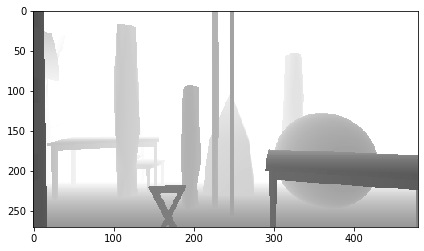

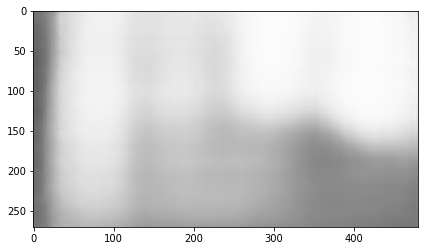

tensor(444.4064, grad_fn=<SumBackward0>) tensor(947.0361, grad_fn=<MseLossBackward0>)
tensor(604.5033, grad_fn=<SubBackward0>)
Epoch: 21/250, Step: 65/65, Avg loss: 787.409, time: 281.21, Avg. per iter 4.35, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data134.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(13095.0078, grad_fn=<SumBackward0>) tensor(40523.3047, grad_fn=<MseLossBackward0>)
tensor(15881.0498, grad_fn=<SubBackward0>)
tensor(15038.1982, grad_fn=<SumBackward0>) tensor(46402.4453, grad_fn=<MseLossBackward0>)
tensor(17746.3965, grad_fn=<SubBackward0>)
tensor(22618.4922, grad_fn=<SumBackward0>) tensor(66304.5312, grad_fn=<MseLossBackward0>)
tensor(25497.1074, grad_fn=<SubBackward0>)
tensor(18829.2852, grad_fn=<SumBackward0>) tensor(63877.9180, grad_fn=<MseLossBackward0>)
tensor(21747.5410, grad_fn=<SubBackward0>)
tensor(22207.0664, grad_fn=<SumBackward0>) tensor(76816.0938, grad_fn=<MseLossBackward0>)
tensor(24839.3027, grad_fn=<SubBackward0>)

tensor(14941.7441, grad_fn=<SumBackward0>) tensor(44523.5312, grad_fn=<MseLossBackward0>)
tensor(17328.5508, grad_fn=<SubBackward0>)
tensor(14440.7412, grad_fn=<SumBackward0>) tensor(44746.9531, grad_fn=<MseLossBackward0>)
tensor(16920.9062, grad_fn=<SubBackward0>)
tensor(17953.9180, grad_fn=<SumBackward0>) tensor(55272.6562, grad_fn=<MseLossBackward0>)
tensor(20581.6680, grad_fn=<SubBackward0>)
Epoch: 22/250, Step: 55/65, Avg loss: 647.999, time: 244.08, Avg. per iter 4.36, Est. time left 43.56

tensor(16648.8750, grad_fn=<SumBackward0>) tensor(46657., grad_fn=<MseLossBackward0>)
tensor(19200.6699, grad_fn=<SubBackward0>)
tensor(20717.2402, grad_fn=<SumBackward0>) tensor(63852.0234, grad_fn=<MseLossBackward0>)
tensor(23491.2891, grad_fn=<SubBackward0>)
tensor(16454.9805, grad_fn=<SumBackward0>) tensor(51568.2070, grad_fn=<MseLossBackward0>)
tensor(19219.3555, grad_fn=<SubBackward0>)
tensor(19032.5898, grad_fn=<SumBackward0>) tensor(59098.4648, grad_fn=<MseLossBackward0>)
tensor(21816.

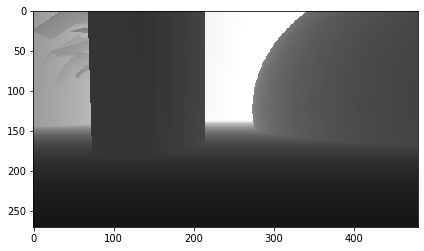

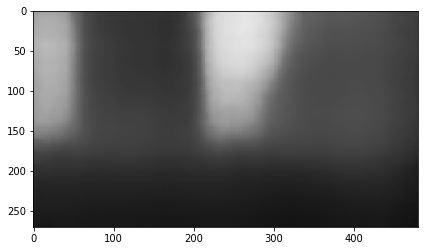

tensor(11184.7617, grad_fn=<SumBackward0>) tensor(36031.9336, grad_fn=<MseLossBackward0>)
tensor(12637.4639, grad_fn=<SubBackward0>)
Epoch: 22/250, Step: 65/65, Avg loss: 641.349, time: 287.24, Avg. per iter 4.36, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data155.tfrecords']
Iterating length... 	Done: 63
gotcha
tensor(18373.9316, grad_fn=<SumBackward0>) tensor(71119.2109, grad_fn=<MseLossBackward0>)
tensor(21119.0293, grad_fn=<SubBackward0>)
tensor(23096.3164, grad_fn=<SumBackward0>) tensor(79650.0156, grad_fn=<MseLossBackward0>)
tensor(25750.7539, grad_fn=<SubBackward0>)
tensor(17347.1992, grad_fn=<SumBackward0>) tensor(56507.4531, grad_fn=<MseLossBackward0>)
tensor(19920.4629, grad_fn=<SubBackward0>)
tensor(23495.8223, grad_fn=<SumBackward0>) tensor(58734.8125, grad_fn=<MseLossBackward0>)
tensor(26503.3945, grad_fn=<SubBackward0>)
tensor(27626.3457, grad_fn=<SumBackward0>) tensor(88646.1797, grad_fn=<MseLossBackward0>)
tensor(30609.3711, grad_fn=<SubBackw

tensor(23778.7676, grad_fn=<SumBackward0>) tensor(71242.1797, grad_fn=<MseLossBackward0>)
tensor(26601.8984, grad_fn=<SubBackward0>)
tensor(23576.2520, grad_fn=<SumBackward0>) tensor(80769.0625, grad_fn=<MseLossBackward0>)
tensor(26450.5547, grad_fn=<SubBackward0>)
tensor(30018.7617, grad_fn=<SumBackward0>) tensor(96617.5938, grad_fn=<MseLossBackward0>)
tensor(32841.2617, grad_fn=<SubBackward0>)
Epoch: 23/250, Step: 55/63, Avg loss: 840.062, time: 246.60, Avg. per iter 4.36, Est. time left 34.88

tensor(26459.8125, grad_fn=<SumBackward0>) tensor(100233.1406, grad_fn=<MseLossBackward0>)
tensor(29130.0391, grad_fn=<SubBackward0>)
tensor(23442.8945, grad_fn=<SumBackward0>) tensor(84794.1094, grad_fn=<MseLossBackward0>)
tensor(26010.9277, grad_fn=<SubBackward0>)
tensor(22463.7930, grad_fn=<SumBackward0>) tensor(79407.2734, grad_fn=<MseLossBackward0>)
tensor(25435.3516, grad_fn=<SubBackward0>)
tensor(24101.8281, grad_fn=<SumBackward0>) tensor(80689.5859, grad_fn=<MseLossBackward0>)
tensor(2

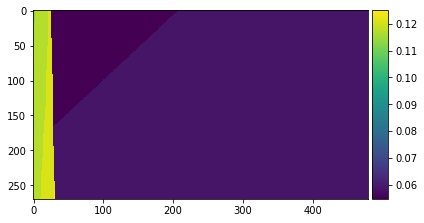

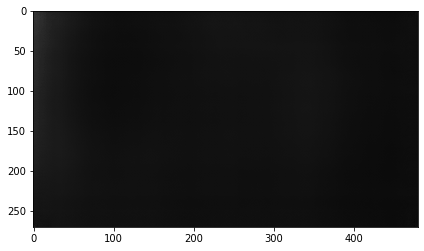

tensor(7197.4941, grad_fn=<SumBackward0>) tensor(24753.0020, grad_fn=<MseLossBackward0>)
tensor(8300.0918, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data106.tfrecords']
Iterating length... 	Done: 68
gotcha
tensor(23882.2461, grad_fn=<SumBackward0>) tensor(86950.8594, grad_fn=<MseLossBackward0>)
tensor(26776.9805, grad_fn=<SubBackward0>)
tensor(17213.2168, grad_fn=<SumBackward0>) tensor(59303.4609, grad_fn=<MseLossBackward0>)
tensor(19893.3359, grad_fn=<SubBackward0>)
tensor(17959.2148, grad_fn=<SumBackward0>) tensor(54181.5430, grad_fn=<MseLossBackward0>)
tensor(20833.4688, grad_fn=<SubBackward0>)
tensor(20083.4395, grad_fn=<SumBackward0>) tensor(56300.1094, grad_fn=<MseLossBackward0>)
tensor(22959.2812, grad_fn=<SubBackward0>)
tensor(17975.1719, grad_fn=<SumBackward0>) tensor(53561.8398, grad_fn=<MseLossBackward0>)
tensor(20583.3496, grad_fn=<SubBackward0>)
Epoch: 24/250, Step: 5/68, Avg loss: 694.040, time: 22.69, Avg. per iter 4.36, Est. time left 274

tensor(16815.4043, grad_fn=<SumBackward0>) tensor(55653.6875, grad_fn=<MseLossBackward0>)
tensor(19535.4297, grad_fn=<SubBackward0>)
tensor(15820.9873, grad_fn=<SumBackward0>) tensor(48913.3945, grad_fn=<MseLossBackward0>)
tensor(18396.0684, grad_fn=<SubBackward0>)
Epoch: 24/250, Step: 55/68, Avg loss: 697.011, time: 247.51, Avg. per iter 4.36, Est. time left 56.73

tensor(19089.7578, grad_fn=<SumBackward0>) tensor(60217.8047, grad_fn=<MseLossBackward0>)
tensor(22079.3867, grad_fn=<SubBackward0>)
tensor(22623.3848, grad_fn=<SumBackward0>) tensor(77333.2344, grad_fn=<MseLossBackward0>)
tensor(25327.4688, grad_fn=<SubBackward0>)
tensor(17205.3770, grad_fn=<SumBackward0>) tensor(52500.9922, grad_fn=<MseLossBackward0>)
tensor(19501.8242, grad_fn=<SubBackward0>)
tensor(18517.7168, grad_fn=<SumBackward0>) tensor(68830.8047, grad_fn=<MseLossBackward0>)
tensor(20911.1836, grad_fn=<SubBackward0>)
tensor(22119.4648, grad_fn=<SumBackward0>) tensor(77397.4062, grad_fn=<MseLossBackward0>)
tensor(24

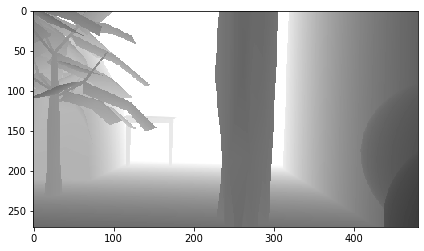

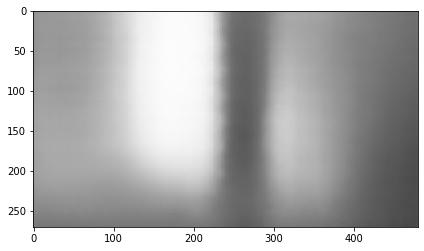

tensor(3699.6289, grad_fn=<SumBackward0>) tensor(10854.0352, grad_fn=<MseLossBackward0>)
tensor(4221.6670, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data25.tfrecords']
Iterating length... 	Done: 74
gotcha
tensor(16407.2695, grad_fn=<SumBackward0>) tensor(60577.4258, grad_fn=<MseLossBackward0>)
tensor(18958.8945, grad_fn=<SubBackward0>)
tensor(23534.0645, grad_fn=<SumBackward0>) tensor(77131.2969, grad_fn=<MseLossBackward0>)
tensor(26368.6992, grad_fn=<SubBackward0>)
tensor(25451.7812, grad_fn=<SumBackward0>) tensor(79093.0156, grad_fn=<MseLossBackward0>)
tensor(28091.1504, grad_fn=<SubBackward0>)
tensor(22479.2344, grad_fn=<SumBackward0>) tensor(66932.0312, grad_fn=<MseLossBackward0>)
tensor(25208.9609, grad_fn=<SubBackward0>)
tensor(17245.0430, grad_fn=<SumBackward0>) tensor(55444.2891, grad_fn=<MseLossBackward0>)
tensor(19842.8984, grad_fn=<SubBackward0>)
Epoch: 25/250, Step: 5/74, Avg loss: 740.441, time: 22.25, Avg. per iter 4.36, Est. time left 300.

tensor(17605.6035, grad_fn=<SumBackward0>) tensor(60933.5469, grad_fn=<MseLossBackward0>)
tensor(20135.6289, grad_fn=<SubBackward0>)
tensor(17460.5352, grad_fn=<SumBackward0>) tensor(58697.9805, grad_fn=<MseLossBackward0>)
tensor(19941.5840, grad_fn=<SubBackward0>)
Epoch: 25/250, Step: 55/74, Avg loss: 723.524, time: 243.62, Avg. per iter 4.36, Est. time left 82.90

tensor(17886.8770, grad_fn=<SumBackward0>) tensor(57751.8594, grad_fn=<MseLossBackward0>)
tensor(20408.5273, grad_fn=<SubBackward0>)
tensor(23388.2188, grad_fn=<SumBackward0>) tensor(84545.0703, grad_fn=<MseLossBackward0>)
tensor(26235.0059, grad_fn=<SubBackward0>)
tensor(18538.3730, grad_fn=<SumBackward0>) tensor(56124.7461, grad_fn=<MseLossBackward0>)
tensor(21132.4746, grad_fn=<SubBackward0>)
tensor(15806.7754, grad_fn=<SumBackward0>) tensor(52668.7266, grad_fn=<MseLossBackward0>)
tensor(18545.2500, grad_fn=<SubBackward0>)
tensor(18330.6758, grad_fn=<SumBackward0>) tensor(60734.7188, grad_fn=<MseLossBackward0>)
tensor(21

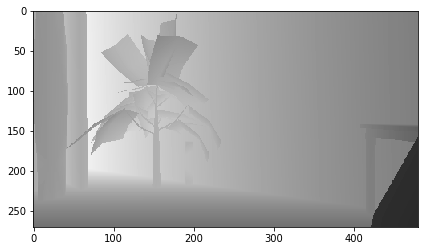

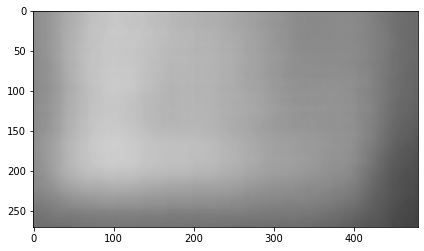

tensor(15515.2041, grad_fn=<SumBackward0>) tensor(59485.9219, grad_fn=<MseLossBackward0>)
tensor(17561.5703, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data133.tfrecords']
Iterating length... 	Done: 55
gotcha
tensor(21835.8008, grad_fn=<SumBackward0>) tensor(70011.9844, grad_fn=<MseLossBackward0>)
tensor(24459.3789, grad_fn=<SubBackward0>)
tensor(26136.4570, grad_fn=<SumBackward0>) tensor(75647.6484, grad_fn=<MseLossBackward0>)
tensor(29100.9746, grad_fn=<SubBackward0>)
tensor(19873.2285, grad_fn=<SumBackward0>) tensor(62412.5156, grad_fn=<MseLossBackward0>)
tensor(22551.2715, grad_fn=<SubBackward0>)
tensor(21437.5625, grad_fn=<SumBackward0>) tensor(74079.2969, grad_fn=<MseLossBackward0>)
tensor(24133.1406, grad_fn=<SubBackward0>)
tensor(19811.7656, grad_fn=<SumBackward0>) tensor(62042.3281, grad_fn=<MseLossBackward0>)
tensor(22559.3613, grad_fn=<SubBackward0>)
Epoch: 26/250, Step: 5/55, Avg loss: 767.526, time: 22.55, Avg. per iter 4.36, Est. time left 2

tensor(25654.9062, grad_fn=<SumBackward0>) tensor(89424.3906, grad_fn=<MseLossBackward0>)
tensor(28793.3438, grad_fn=<SubBackward0>)


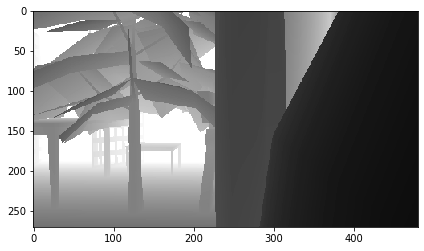

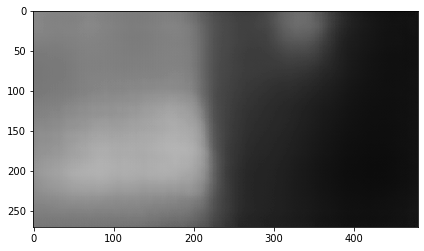

tensor(12001.9248, grad_fn=<SumBackward0>) tensor(37496.2344, grad_fn=<MseLossBackward0>)
tensor(13932.5635, grad_fn=<SubBackward0>)
Epoch: 26/250, Step: 55/55, Avg loss: 766.229, time: 245.11, Avg. per iter 4.37, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data75.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(17420.5645, grad_fn=<SumBackward0>) tensor(48359.8594, grad_fn=<MseLossBackward0>)
tensor(20215.5215, grad_fn=<SubBackward0>)
tensor(26439.2617, grad_fn=<SumBackward0>) tensor(74779.2812, grad_fn=<MseLossBackward0>)
tensor(29134.3730, grad_fn=<SubBackward0>)
tensor(20224.5508, grad_fn=<SumBackward0>) tensor(66152.4062, grad_fn=<MseLossBackward0>)
tensor(23038.4434, grad_fn=<SubBackward0>)
tensor(20376.2773, grad_fn=<SumBackward0>) tensor(66328.6719, grad_fn=<MseLossBackward0>)
tensor(22967.2969, grad_fn=<SubBackward0>)
tensor(25190.5215, grad_fn=<SumBackward0>) tensor(83719.4531, grad_fn=<MseLossBackward0>)
tensor(27782.9805, grad_fn=<SubBackwa

tensor(18853.2500, grad_fn=<SumBackward0>) tensor(64969.2656, grad_fn=<MseLossBackward0>)
tensor(21963.0625, grad_fn=<SubBackward0>)
tensor(13639.4512, grad_fn=<SumBackward0>) tensor(48418.3477, grad_fn=<MseLossBackward0>)
tensor(16402.3516, grad_fn=<SubBackward0>)
tensor(14234.0391, grad_fn=<SumBackward0>) tensor(50040.4062, grad_fn=<MseLossBackward0>)
tensor(16903.5977, grad_fn=<SubBackward0>)
Epoch: 27/250, Step: 55/61, Avg loss: 762.017, time: 253.78, Avg. per iter 4.37, Est. time left 26.24

tensor(23548.8848, grad_fn=<SumBackward0>) tensor(74664.1250, grad_fn=<MseLossBackward0>)
tensor(26178.4062, grad_fn=<SubBackward0>)
tensor(21186.8945, grad_fn=<SumBackward0>) tensor(76306.4844, grad_fn=<MseLossBackward0>)
tensor(24108.1133, grad_fn=<SubBackward0>)
tensor(17883.1211, grad_fn=<SumBackward0>) tensor(59867.2031, grad_fn=<MseLossBackward0>)
tensor(20467.1953, grad_fn=<SubBackward0>)
tensor(18779.8418, grad_fn=<SumBackward0>) tensor(60068.8008, grad_fn=<MseLossBackward0>)
tensor(21

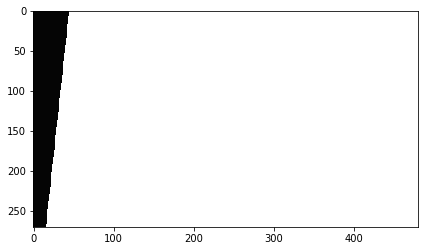

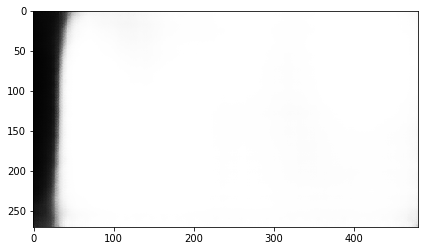

tensor(18176.8145, grad_fn=<SumBackward0>) tensor(42604.6445, grad_fn=<MseLossBackward0>)
tensor(20512.8398, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data109.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(24774.2773, grad_fn=<SumBackward0>) tensor(84747.4062, grad_fn=<MseLossBackward0>)
tensor(27704.9609, grad_fn=<SubBackward0>)
tensor(26534.3320, grad_fn=<SumBackward0>) tensor(90116.9609, grad_fn=<MseLossBackward0>)
tensor(29316.3242, grad_fn=<SubBackward0>)
tensor(22418.8398, grad_fn=<SumBackward0>) tensor(84666.2891, grad_fn=<MseLossBackward0>)
tensor(25157.7891, grad_fn=<SubBackward0>)
tensor(24112.5586, grad_fn=<SumBackward0>) tensor(81132.2969, grad_fn=<MseLossBackward0>)
tensor(27051.8477, grad_fn=<SubBackward0>)
tensor(23665.9453, grad_fn=<SumBackward0>) tensor(63100.5820, grad_fn=<MseLossBackward0>)
tensor(26717.5234, grad_fn=<SubBackward0>)
Epoch: 28/250, Step: 5/65, Avg loss: 849.678, time: 21.89, Avg. per iter 4.37, Est. time left 2

tensor(26214.5820, grad_fn=<SumBackward0>) tensor(81463.6875, grad_fn=<MseLossBackward0>)
tensor(29108.7578, grad_fn=<SubBackward0>)
tensor(25894.3516, grad_fn=<SumBackward0>) tensor(85259.2344, grad_fn=<MseLossBackward0>)
tensor(28729.5547, grad_fn=<SubBackward0>)
Epoch: 28/250, Step: 55/65, Avg loss: 799.008, time: 244.33, Avg. per iter 4.38, Est. time left 43.75

tensor(19933.1094, grad_fn=<SumBackward0>) tensor(68351.1953, grad_fn=<MseLossBackward0>)
tensor(22586.0078, grad_fn=<SubBackward0>)
tensor(18455.8613, grad_fn=<SumBackward0>) tensor(64966.4492, grad_fn=<MseLossBackward0>)
tensor(21207.7500, grad_fn=<SubBackward0>)
tensor(24477.1621, grad_fn=<SumBackward0>) tensor(74844.3750, grad_fn=<MseLossBackward0>)
tensor(27151.7500, grad_fn=<SubBackward0>)
tensor(22670.5215, grad_fn=<SumBackward0>) tensor(67334.9375, grad_fn=<MseLossBackward0>)
tensor(25418.6523, grad_fn=<SubBackward0>)
tensor(15965.2949, grad_fn=<SumBackward0>) tensor(55174.9414, grad_fn=<MseLossBackward0>)
tensor(18

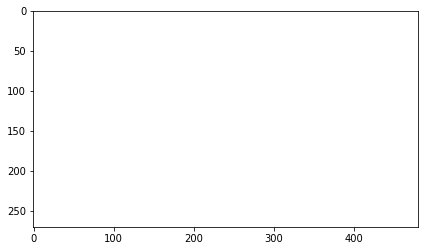

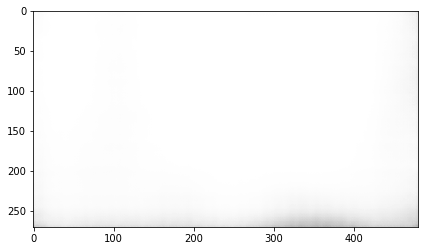

tensor(13845.5781, grad_fn=<SumBackward0>) tensor(48355.8750, grad_fn=<MseLossBackward0>)
tensor(15537.8135, grad_fn=<SubBackward0>)
Epoch: 28/250, Step: 65/65, Avg loss: 789.025, time: 289.10, Avg. per iter 4.38, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data36.tfrecords']
Iterating length... 	Done: 78
gotcha
tensor(19391.1289, grad_fn=<SumBackward0>) tensor(73213.0781, grad_fn=<MseLossBackward0>)
tensor(22007.3379, grad_fn=<SubBackward0>)
tensor(16318.0225, grad_fn=<SumBackward0>) tensor(59329.0703, grad_fn=<MseLossBackward0>)
tensor(18967.7344, grad_fn=<SubBackward0>)
tensor(19858.0469, grad_fn=<SumBackward0>) tensor(72402.7500, grad_fn=<MseLossBackward0>)
tensor(22616.2734, grad_fn=<SubBackward0>)
tensor(18262.4629, grad_fn=<SumBackward0>) tensor(68839.5312, grad_fn=<MseLossBackward0>)
tensor(20925.0254, grad_fn=<SubBackward0>)
tensor(17085.1543, grad_fn=<SumBackward0>) tensor(59501.3828, grad_fn=<MseLossBackward0>)
tensor(19800.3984, grad_fn=<SubBackwa

tensor(21355.8203, grad_fn=<SumBackward0>) tensor(75936.9766, grad_fn=<MseLossBackward0>)
tensor(24130.7305, grad_fn=<SubBackward0>)
tensor(14353.2881, grad_fn=<SumBackward0>) tensor(48257.4453, grad_fn=<MseLossBackward0>)
tensor(16816.3203, grad_fn=<SubBackward0>)
tensor(18026.5176, grad_fn=<SumBackward0>) tensor(62886.9102, grad_fn=<MseLossBackward0>)
tensor(20640.2891, grad_fn=<SubBackward0>)
Epoch: 29/250, Step: 55/78, Avg loss: 665.371, time: 243.67, Avg. per iter 4.38, Est. time left 100.67

tensor(21507.6758, grad_fn=<SumBackward0>) tensor(69119.7656, grad_fn=<MseLossBackward0>)
tensor(24147.1055, grad_fn=<SubBackward0>)
tensor(20155.6562, grad_fn=<SumBackward0>) tensor(71353.3984, grad_fn=<MseLossBackward0>)
tensor(22756.4688, grad_fn=<SubBackward0>)
tensor(18215.8145, grad_fn=<SumBackward0>) tensor(68838.0391, grad_fn=<MseLossBackward0>)
tensor(20778.3047, grad_fn=<SubBackward0>)
tensor(15894.7090, grad_fn=<SumBackward0>) tensor(56184.8320, grad_fn=<MseLossBackward0>)
tensor(1

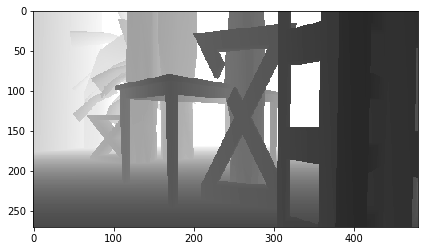

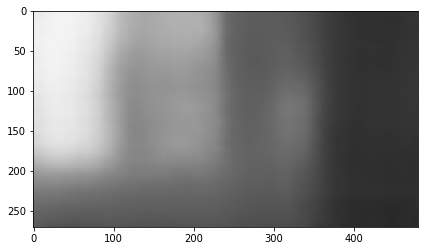

tensor(10873.0830, grad_fn=<SumBackward0>) tensor(33919.4688, grad_fn=<MseLossBackward0>)
tensor(12760.2617, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data151.tfrecords']
Iterating length... 	Done: 69
gotcha
tensor(19543.4043, grad_fn=<SumBackward0>) tensor(57815.8516, grad_fn=<MseLossBackward0>)
tensor(22265.8750, grad_fn=<SubBackward0>)
tensor(19414.5547, grad_fn=<SumBackward0>) tensor(62744.3281, grad_fn=<MseLossBackward0>)
tensor(22085.1406, grad_fn=<SubBackward0>)
tensor(13096.4424, grad_fn=<SumBackward0>) tensor(41215.6367, grad_fn=<MseLossBackward0>)
tensor(15691.9170, grad_fn=<SubBackward0>)
tensor(16746.4180, grad_fn=<SumBackward0>) tensor(53066.2148, grad_fn=<MseLossBackward0>)
tensor(19119.8047, grad_fn=<SubBackward0>)
tensor(15600.0459, grad_fn=<SumBackward0>) tensor(52381.1523, grad_fn=<MseLossBackward0>)
tensor(18162.9570, grad_fn=<SubBackward0>)
Epoch: 30/250, Step: 5/69, Avg loss: 608.286, time: 22.72, Avg. per iter 4.38, Est. time left 2

tensor(18333.0430, grad_fn=<SumBackward0>) tensor(61483.1172, grad_fn=<MseLossBackward0>)
tensor(20965.4180, grad_fn=<SubBackward0>)
tensor(19673.8945, grad_fn=<SumBackward0>) tensor(59816.6719, grad_fn=<MseLossBackward0>)
tensor(22293.5391, grad_fn=<SubBackward0>)
Epoch: 30/250, Step: 55/69, Avg loss: 694.907, time: 243.26, Avg. per iter 4.38, Est. time left 61.29

tensor(20573.4688, grad_fn=<SumBackward0>) tensor(61440.3242, grad_fn=<MseLossBackward0>)
tensor(22989.5547, grad_fn=<SubBackward0>)
tensor(15442.6191, grad_fn=<SumBackward0>) tensor(52164.8906, grad_fn=<MseLossBackward0>)
tensor(17949.1191, grad_fn=<SubBackward0>)
tensor(13109.8408, grad_fn=<SumBackward0>) tensor(40128.8242, grad_fn=<MseLossBackward0>)
tensor(15435.9854, grad_fn=<SubBackward0>)
tensor(20932.5781, grad_fn=<SumBackward0>) tensor(64307.2305, grad_fn=<MseLossBackward0>)
tensor(23452.4883, grad_fn=<SubBackward0>)
tensor(17940.1621, grad_fn=<SumBackward0>) tensor(52159.1250, grad_fn=<MseLossBackward0>)
tensor(20

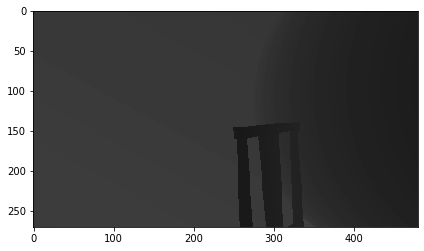

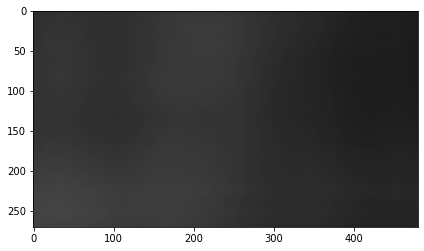

tensor(1472.5896, grad_fn=<SumBackward0>) tensor(3779.1475, grad_fn=<MseLossBackward0>)
tensor(1780.4257, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data166.tfrecords']
Iterating length... 	Done: 57
gotcha
tensor(12830.3203, grad_fn=<SumBackward0>) tensor(32374.7949, grad_fn=<MseLossBackward0>)
tensor(15461.9844, grad_fn=<SubBackward0>)
tensor(16458.6543, grad_fn=<SumBackward0>) tensor(46543.0312, grad_fn=<MseLossBackward0>)
tensor(19139.6094, grad_fn=<SubBackward0>)
tensor(16170.1260, grad_fn=<SumBackward0>) tensor(56438.1016, grad_fn=<MseLossBackward0>)
tensor(18798.3848, grad_fn=<SubBackward0>)
tensor(16990.4551, grad_fn=<SumBackward0>) tensor(57100.0742, grad_fn=<MseLossBackward0>)
tensor(19513.5410, grad_fn=<SubBackward0>)
tensor(16083.5303, grad_fn=<SumBackward0>) tensor(55878.4258, grad_fn=<MseLossBackward0>)
tensor(18859.6309, grad_fn=<SubBackward0>)
Epoch: 31/250, Step: 5/57, Avg loss: 573.582, time: 21.43, Avg. per iter 4.38, Est. time left 227.

tensor(16753.6484, grad_fn=<SumBackward0>) tensor(56845.7383, grad_fn=<MseLossBackward0>)
tensor(19214.9805, grad_fn=<SubBackward0>)
tensor(18620.2500, grad_fn=<SumBackward0>) tensor(70328.0859, grad_fn=<MseLossBackward0>)
tensor(20836.0488, grad_fn=<SubBackward0>)
Epoch: 31/250, Step: 55/57, Avg loss: 629.242, time: 244.30, Avg. per iter 4.38, Est. time left 8.75

tensor(17418.2734, grad_fn=<SumBackward0>) tensor(44894.4922, grad_fn=<MseLossBackward0>)
tensor(19654.4902, grad_fn=<SubBackward0>)


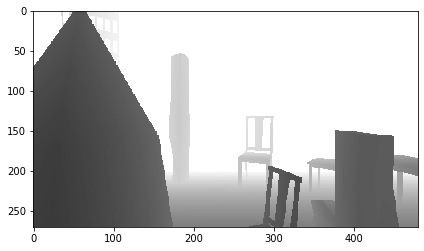

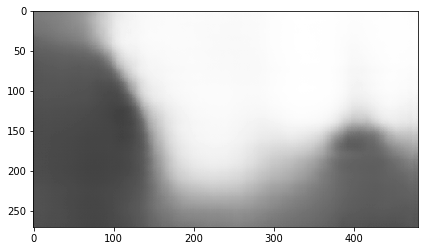

tensor(6518.2261, grad_fn=<SumBackward0>) tensor(18820.7285, grad_fn=<MseLossBackward0>)
tensor(7576.2715, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data24.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(21482.7148, grad_fn=<SumBackward0>) tensor(72714.0703, grad_fn=<MseLossBackward0>)
tensor(24096.7168, grad_fn=<SubBackward0>)
tensor(31332.4922, grad_fn=<SumBackward0>) tensor(108254.2578, grad_fn=<MseLossBackward0>)
tensor(34417.8359, grad_fn=<SubBackward0>)
tensor(22220.1875, grad_fn=<SumBackward0>) tensor(74716.5000, grad_fn=<MseLossBackward0>)
tensor(25167.6660, grad_fn=<SubBackward0>)
tensor(23505.9922, grad_fn=<SumBackward0>) tensor(72302.7656, grad_fn=<MseLossBackward0>)
tensor(26348.8867, grad_fn=<SubBackward0>)
tensor(30222.1289, grad_fn=<SumBackward0>) tensor(85715.9453, grad_fn=<MseLossBackward0>)
tensor(33293.0312, grad_fn=<SubBackward0>)
Epoch: 32/250, Step: 5/61, Avg loss: 895.776, time: 22.26, Avg. per iter 4.38, Est. time left 245

tensor(20428.9199, grad_fn=<SumBackward0>) tensor(73276.1719, grad_fn=<MseLossBackward0>)
tensor(23070.9570, grad_fn=<SubBackward0>)
tensor(20425.3613, grad_fn=<SumBackward0>) tensor(72235.5000, grad_fn=<MseLossBackward0>)
tensor(23090.9180, grad_fn=<SubBackward0>)
Epoch: 32/250, Step: 55/61, Avg loss: 791.966, time: 239.40, Avg. per iter 4.37, Est. time left 26.25

tensor(21621.4453, grad_fn=<SumBackward0>) tensor(69413.4297, grad_fn=<MseLossBackward0>)
tensor(24213.8594, grad_fn=<SubBackward0>)
tensor(22966.7559, grad_fn=<SumBackward0>) tensor(71084.2812, grad_fn=<MseLossBackward0>)
tensor(25718.7344, grad_fn=<SubBackward0>)
tensor(23115.2344, grad_fn=<SumBackward0>) tensor(75010.8047, grad_fn=<MseLossBackward0>)
tensor(26095.9844, grad_fn=<SubBackward0>)
tensor(18111.1406, grad_fn=<SumBackward0>) tensor(60206.3438, grad_fn=<MseLossBackward0>)
tensor(20933.9395, grad_fn=<SubBackward0>)
tensor(21543.1211, grad_fn=<SumBackward0>) tensor(81280.3281, grad_fn=<MseLossBackward0>)
tensor(24

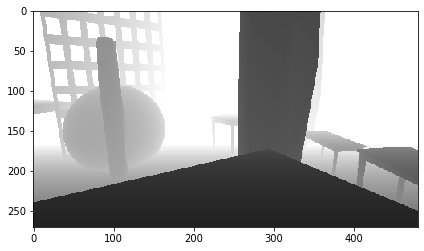

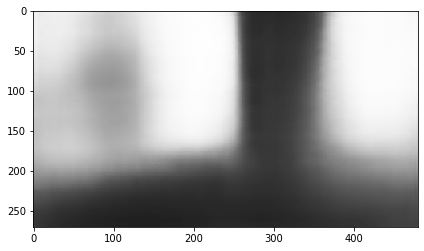

tensor(14959.5352, grad_fn=<SumBackward0>) tensor(50491.1758, grad_fn=<MseLossBackward0>)
tensor(16824.7188, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data15.tfrecords']
Iterating length... 	Done: 55
gotcha
tensor(18742.0762, grad_fn=<SumBackward0>) tensor(54812.0312, grad_fn=<MseLossBackward0>)
tensor(21307.2344, grad_fn=<SubBackward0>)
tensor(14493.0127, grad_fn=<SumBackward0>) tensor(45887.6719, grad_fn=<MseLossBackward0>)
tensor(17028.4531, grad_fn=<SubBackward0>)
tensor(16671.7578, grad_fn=<SumBackward0>) tensor(56328.0430, grad_fn=<MseLossBackward0>)
tensor(19247.8008, grad_fn=<SubBackward0>)
tensor(19852.0781, grad_fn=<SumBackward0>) tensor(65128.1992, grad_fn=<MseLossBackward0>)
tensor(22802.7969, grad_fn=<SubBackward0>)
tensor(22674.6133, grad_fn=<SumBackward0>) tensor(64400.5742, grad_fn=<MseLossBackward0>)
tensor(25502.5312, grad_fn=<SubBackward0>)
Epoch: 33/250, Step: 5/55, Avg loss: 661.805, time: 21.73, Avg. per iter 4.37, Est. time left 21

tensor(17689.8008, grad_fn=<SumBackward0>) tensor(58675.5898, grad_fn=<MseLossBackward0>)
tensor(20575.6328, grad_fn=<SubBackward0>)


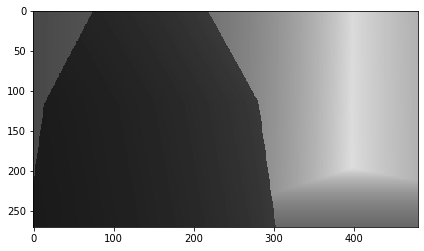

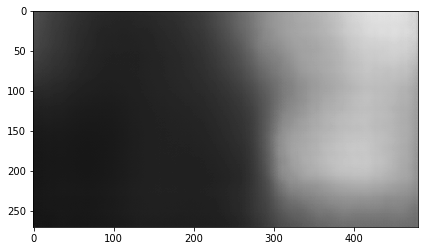

tensor(10404.1006, grad_fn=<SumBackward0>) tensor(33480.9688, grad_fn=<MseLossBackward0>)
tensor(11977.7178, grad_fn=<SubBackward0>)
Epoch: 33/250, Step: 55/55, Avg loss: 701.582, time: 236.48, Avg. per iter 4.37, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data171.tfrecords']
Iterating length... 	Done: 63
gotcha
tensor(22568.0156, grad_fn=<SumBackward0>) tensor(73230.0391, grad_fn=<MseLossBackward0>)
tensor(25687.7539, grad_fn=<SubBackward0>)
tensor(22151.7500, grad_fn=<SumBackward0>) tensor(67993.8438, grad_fn=<MseLossBackward0>)
tensor(24860.5703, grad_fn=<SubBackward0>)
tensor(23823.4395, grad_fn=<SumBackward0>) tensor(78665.4375, grad_fn=<MseLossBackward0>)
tensor(26669.7695, grad_fn=<SubBackward0>)
tensor(20334.9219, grad_fn=<SumBackward0>) tensor(71267.5547, grad_fn=<MseLossBackward0>)
tensor(23058.6094, grad_fn=<SubBackward0>)
tensor(16915.0234, grad_fn=<SumBackward0>) tensor(60727.3164, grad_fn=<MseLossBackward0>)
tensor(19463.9727, grad_fn=<SubBackw

tensor(16716.4961, grad_fn=<SumBackward0>) tensor(57394.3398, grad_fn=<MseLossBackward0>)
tensor(19403.5957, grad_fn=<SubBackward0>)
tensor(17690.7578, grad_fn=<SumBackward0>) tensor(48070.4062, grad_fn=<MseLossBackward0>)
tensor(20544.2207, grad_fn=<SubBackward0>)
tensor(19729.6191, grad_fn=<SumBackward0>) tensor(63142.2070, grad_fn=<MseLossBackward0>)
tensor(22175.4570, grad_fn=<SubBackward0>)
Epoch: 34/250, Step: 55/63, Avg loss: 683.822, time: 247.41, Avg. per iter 4.37, Est. time left 35.00

tensor(16961.5801, grad_fn=<SumBackward0>) tensor(54568.9297, grad_fn=<MseLossBackward0>)
tensor(19396.6953, grad_fn=<SubBackward0>)
tensor(18009.5273, grad_fn=<SumBackward0>) tensor(66891.6328, grad_fn=<MseLossBackward0>)
tensor(20503.2324, grad_fn=<SubBackward0>)
tensor(16467.4395, grad_fn=<SumBackward0>) tensor(53674.6094, grad_fn=<MseLossBackward0>)
tensor(18949.7305, grad_fn=<SubBackward0>)
tensor(17632.0859, grad_fn=<SumBackward0>) tensor(62486.5859, grad_fn=<MseLossBackward0>)
tensor(20

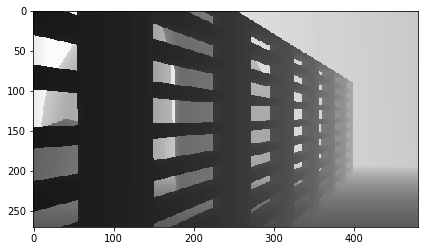

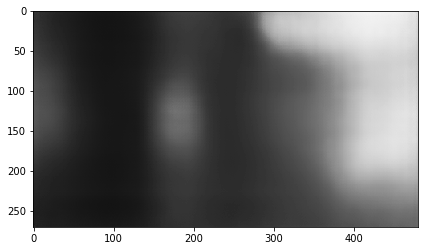

tensor(817.2550, grad_fn=<SumBackward0>) tensor(2148.4600, grad_fn=<MseLossBackward0>)
tensor(990.6582, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data138.tfrecords']
Iterating length... 	Done: 67
gotcha
tensor(19137.5762, grad_fn=<SumBackward0>) tensor(56071.4336, grad_fn=<MseLossBackward0>)
tensor(21899.2578, grad_fn=<SubBackward0>)
tensor(19846.5273, grad_fn=<SumBackward0>) tensor(58368.2070, grad_fn=<MseLossBackward0>)
tensor(22678.3574, grad_fn=<SubBackward0>)
tensor(16519.6719, grad_fn=<SumBackward0>) tensor(60505.5781, grad_fn=<MseLossBackward0>)
tensor(19109.2441, grad_fn=<SubBackward0>)
tensor(19365.8672, grad_fn=<SumBackward0>) tensor(71324.5938, grad_fn=<MseLossBackward0>)
tensor(21954.7852, grad_fn=<SubBackward0>)
tensor(19093.8652, grad_fn=<SumBackward0>) tensor(74268.0703, grad_fn=<MseLossBackward0>)
tensor(21585.9824, grad_fn=<SubBackward0>)
Epoch: 35/250, Step: 5/67, Avg loss: 670.173, time: 25.82, Avg. per iter 4.38, Est. time left 271.30

tensor(18301.5742, grad_fn=<SumBackward0>) tensor(59117.2266, grad_fn=<MseLossBackward0>)
tensor(21040.5156, grad_fn=<SubBackward0>)
tensor(20512.2461, grad_fn=<SumBackward0>) tensor(70568.6719, grad_fn=<MseLossBackward0>)
tensor(23389.4492, grad_fn=<SubBackward0>)
Epoch: 35/250, Step: 55/67, Avg loss: 690.098, time: 248.48, Avg. per iter 4.38, Est. time left 52.53

tensor(19269.3867, grad_fn=<SumBackward0>) tensor(63778.2031, grad_fn=<MseLossBackward0>)
tensor(21943.6719, grad_fn=<SubBackward0>)
tensor(23904.2266, grad_fn=<SumBackward0>) tensor(83785.4688, grad_fn=<MseLossBackward0>)
tensor(26769.1035, grad_fn=<SubBackward0>)
tensor(15735.3457, grad_fn=<SumBackward0>) tensor(57915.8594, grad_fn=<MseLossBackward0>)
tensor(18353.7656, grad_fn=<SubBackward0>)
tensor(18448.1953, grad_fn=<SumBackward0>) tensor(66159.9141, grad_fn=<MseLossBackward0>)
tensor(21109.1680, grad_fn=<SubBackward0>)
tensor(17094.9180, grad_fn=<SumBackward0>) tensor(59332.4883, grad_fn=<MseLossBackward0>)
tensor(19

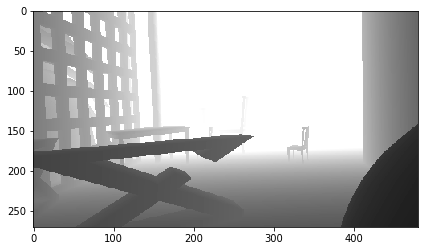

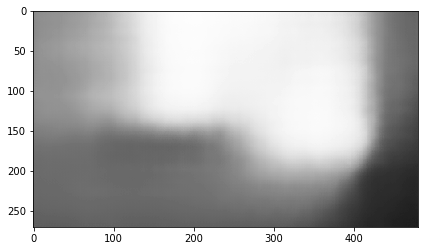

tensor(10418.9180, grad_fn=<SumBackward0>) tensor(35813.6172, grad_fn=<MseLossBackward0>)
tensor(11727.7393, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data12.tfrecords']
Iterating length... 	Done: 57
gotcha
tensor(15143.8184, grad_fn=<SumBackward0>) tensor(38379.9414, grad_fn=<MseLossBackward0>)
tensor(17876.2461, grad_fn=<SubBackward0>)
tensor(25165.8613, grad_fn=<SumBackward0>) tensor(68231.5938, grad_fn=<MseLossBackward0>)
tensor(28093.1094, grad_fn=<SubBackward0>)
tensor(23312.9766, grad_fn=<SumBackward0>) tensor(69924.9531, grad_fn=<MseLossBackward0>)
tensor(26001.0918, grad_fn=<SubBackward0>)
tensor(18447.7402, grad_fn=<SumBackward0>) tensor(68565.4609, grad_fn=<MseLossBackward0>)
tensor(21319.7930, grad_fn=<SubBackward0>)
tensor(20476.1016, grad_fn=<SumBackward0>) tensor(69884.2812, grad_fn=<MseLossBackward0>)
tensor(23185.6367, grad_fn=<SubBackward0>)
Epoch: 36/250, Step: 5/57, Avg loss: 727.974, time: 21.51, Avg. per iter 4.38, Est. time left 22

tensor(15615.8750, grad_fn=<SumBackward0>) tensor(48262.5430, grad_fn=<MseLossBackward0>)
tensor(18318.7461, grad_fn=<SubBackward0>)
tensor(19949.5664, grad_fn=<SumBackward0>) tensor(60732.0469, grad_fn=<MseLossBackward0>)
tensor(22978.0254, grad_fn=<SubBackward0>)
Epoch: 36/250, Step: 55/57, Avg loss: 668.987, time: 236.46, Avg. per iter 4.38, Est. time left 8.75

tensor(13708.6406, grad_fn=<SumBackward0>) tensor(42544.5000, grad_fn=<MseLossBackward0>)
tensor(16301.6250, grad_fn=<SubBackward0>)


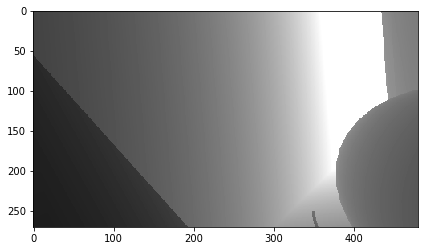

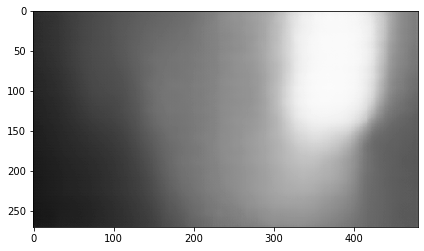

tensor(9435.3750, grad_fn=<SumBackward0>) tensor(25502.7344, grad_fn=<MseLossBackward0>)
tensor(10982.6406, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data68.tfrecords']
Iterating length... 	Done: 62
gotcha
tensor(23022.5625, grad_fn=<SumBackward0>) tensor(79443.7344, grad_fn=<MseLossBackward0>)
tensor(25438.1602, grad_fn=<SubBackward0>)
tensor(19766.8008, grad_fn=<SumBackward0>) tensor(59221.8359, grad_fn=<MseLossBackward0>)
tensor(22146.9043, grad_fn=<SubBackward0>)
tensor(17881.7285, grad_fn=<SumBackward0>) tensor(62792.0352, grad_fn=<MseLossBackward0>)
tensor(20388.7539, grad_fn=<SubBackward0>)
tensor(20137.8926, grad_fn=<SumBackward0>) tensor(62421.5078, grad_fn=<MseLossBackward0>)
tensor(22896.4414, grad_fn=<SubBackward0>)
tensor(22166.8340, grad_fn=<SumBackward0>) tensor(73459.5469, grad_fn=<MseLossBackward0>)
tensor(24956.2461, grad_fn=<SubBackward0>)
Epoch: 37/250, Step: 5/62, Avg loss: 723.916, time: 22.31, Avg. per iter 4.37, Est. time left 249

tensor(22019.9492, grad_fn=<SumBackward0>) tensor(74497.0234, grad_fn=<MseLossBackward0>)
tensor(24859.0469, grad_fn=<SubBackward0>)
tensor(21451.0742, grad_fn=<SumBackward0>) tensor(76675.0156, grad_fn=<MseLossBackward0>)
tensor(24486.9375, grad_fn=<SubBackward0>)
Epoch: 37/250, Step: 55/62, Avg loss: 728.751, time: 238.48, Avg. per iter 4.37, Est. time left 30.62

tensor(23171.3984, grad_fn=<SumBackward0>) tensor(76047.0312, grad_fn=<MseLossBackward0>)
tensor(25988.1406, grad_fn=<SubBackward0>)
tensor(23766.7168, grad_fn=<SumBackward0>) tensor(81850.5156, grad_fn=<MseLossBackward0>)
tensor(26407.2832, grad_fn=<SubBackward0>)
tensor(25434.4531, grad_fn=<SumBackward0>) tensor(79937.4375, grad_fn=<MseLossBackward0>)
tensor(28256.2754, grad_fn=<SubBackward0>)
tensor(17561.4062, grad_fn=<SumBackward0>) tensor(57703.0898, grad_fn=<MseLossBackward0>)
tensor(20142.2832, grad_fn=<SubBackward0>)
tensor(23440.3066, grad_fn=<SumBackward0>) tensor(82748.2031, grad_fn=<MseLossBackward0>)
tensor(25

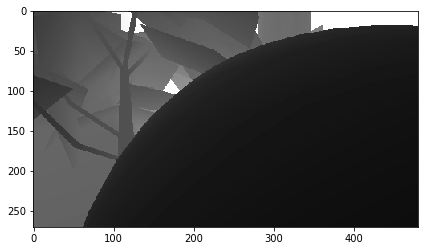

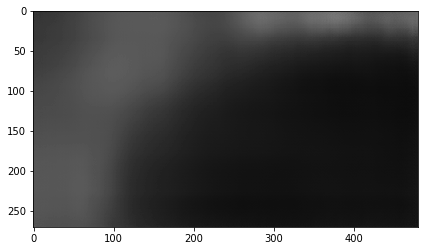

tensor(8005.4941, grad_fn=<SumBackward0>) tensor(25093.1758, grad_fn=<MseLossBackward0>)
tensor(8818.5322, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data174.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(18194.1426, grad_fn=<SumBackward0>) tensor(58918.9844, grad_fn=<MseLossBackward0>)
tensor(20685.3398, grad_fn=<SubBackward0>)
tensor(16177.6807, grad_fn=<SumBackward0>) tensor(53649.1719, grad_fn=<MseLossBackward0>)
tensor(18833.2148, grad_fn=<SubBackward0>)
tensor(18750.3223, grad_fn=<SumBackward0>) tensor(70749.8203, grad_fn=<MseLossBackward0>)
tensor(21480.9082, grad_fn=<SubBackward0>)
tensor(19857.5684, grad_fn=<SumBackward0>) tensor(66061.4922, grad_fn=<MseLossBackward0>)
tensor(22648.5723, grad_fn=<SubBackward0>)
tensor(19060.9160, grad_fn=<SumBackward0>) tensor(59597.2617, grad_fn=<MseLossBackward0>)
tensor(21588.5293, grad_fn=<SubBackward0>)
Epoch: 38/250, Step: 5/61, Avg loss: 657.729, time: 21.00, Avg. per iter 4.37, Est. time left 244

tensor(16412.2988, grad_fn=<SumBackward0>) tensor(55080.0586, grad_fn=<MseLossBackward0>)
tensor(18905.5898, grad_fn=<SubBackward0>)
tensor(25652.2578, grad_fn=<SumBackward0>) tensor(85672.1797, grad_fn=<MseLossBackward0>)
tensor(28038.0098, grad_fn=<SubBackward0>)
Epoch: 38/250, Step: 55/61, Avg loss: 701.129, time: 237.83, Avg. per iter 4.37, Est. time left 26.22

tensor(22056.5469, grad_fn=<SumBackward0>) tensor(70681.7812, grad_fn=<MseLossBackward0>)
tensor(24390.4766, grad_fn=<SubBackward0>)
tensor(23235.4414, grad_fn=<SumBackward0>) tensor(84205.4219, grad_fn=<MseLossBackward0>)
tensor(25731.7305, grad_fn=<SubBackward0>)
tensor(24699.1875, grad_fn=<SumBackward0>) tensor(84745.3906, grad_fn=<MseLossBackward0>)
tensor(27294.4883, grad_fn=<SubBackward0>)
tensor(16223.4824, grad_fn=<SumBackward0>) tensor(55837.3164, grad_fn=<MseLossBackward0>)
tensor(18702.1367, grad_fn=<SubBackward0>)
tensor(29064.4492, grad_fn=<SumBackward0>) tensor(97653.0859, grad_fn=<MseLossBackward0>)
tensor(32

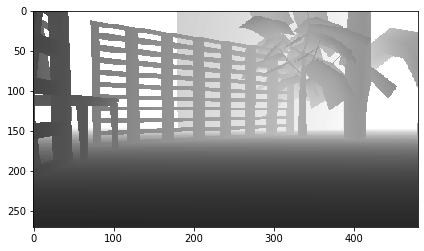

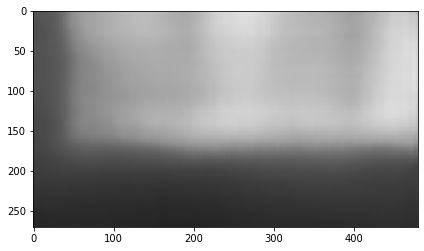

tensor(2295.6509, grad_fn=<SumBackward0>) tensor(6581.4907, grad_fn=<MseLossBackward0>)
tensor(2576.2556, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data166.tfrecords']
Iterating length... 	Done: 57
gotcha
tensor(17515.5234, grad_fn=<SumBackward0>) tensor(56806.8438, grad_fn=<MseLossBackward0>)
tensor(20272.0078, grad_fn=<SubBackward0>)
tensor(17819.3633, grad_fn=<SumBackward0>) tensor(62193.4531, grad_fn=<MseLossBackward0>)
tensor(20371.7090, grad_fn=<SubBackward0>)
tensor(18736.0098, grad_fn=<SumBackward0>) tensor(57211.0977, grad_fn=<MseLossBackward0>)
tensor(21334.3301, grad_fn=<SubBackward0>)
tensor(19860.3945, grad_fn=<SumBackward0>) tensor(62947.5117, grad_fn=<MseLossBackward0>)
tensor(22371.7109, grad_fn=<SubBackward0>)
tensor(16830.5234, grad_fn=<SumBackward0>) tensor(57402.5156, grad_fn=<MseLossBackward0>)
tensor(19161.5508, grad_fn=<SubBackward0>)
Epoch: 39/250, Step: 5/57, Avg loss: 646.946, time: 22.66, Avg. per iter 4.37, Est. time left 227.

tensor(14478.2666, grad_fn=<SumBackward0>) tensor(45930.3086, grad_fn=<MseLossBackward0>)
tensor(16964.8516, grad_fn=<SubBackward0>)
tensor(17377.0254, grad_fn=<SumBackward0>) tensor(57713.5078, grad_fn=<MseLossBackward0>)
tensor(19901.5723, grad_fn=<SubBackward0>)
Epoch: 39/250, Step: 55/57, Avg loss: 574.674, time: 243.47, Avg. per iter 4.37, Est. time left 8.74

tensor(16911.0234, grad_fn=<SumBackward0>) tensor(54098.8711, grad_fn=<MseLossBackward0>)
tensor(19533.0625, grad_fn=<SubBackward0>)


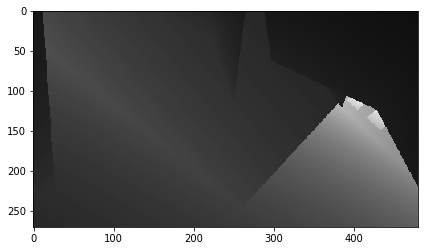

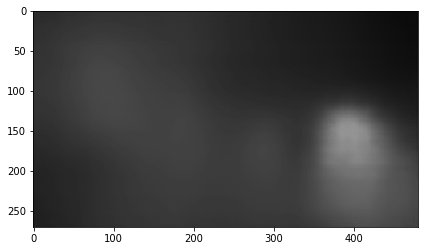

tensor(8906.6914, grad_fn=<SumBackward0>) tensor(23088.4062, grad_fn=<MseLossBackward0>)
tensor(10128.6982, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data133.tfrecords']
Iterating length... 	Done: 55
gotcha
tensor(19145.6719, grad_fn=<SumBackward0>) tensor(53300.1602, grad_fn=<MseLossBackward0>)
tensor(21552.2363, grad_fn=<SubBackward0>)
tensor(19866.5977, grad_fn=<SumBackward0>) tensor(68563.4766, grad_fn=<MseLossBackward0>)
tensor(22447.0410, grad_fn=<SubBackward0>)
tensor(21057.3066, grad_fn=<SumBackward0>) tensor(73027.7344, grad_fn=<MseLossBackward0>)
tensor(23310.6270, grad_fn=<SubBackward0>)
tensor(17185.3125, grad_fn=<SumBackward0>) tensor(55457.5938, grad_fn=<MseLossBackward0>)
tensor(19306.2715, grad_fn=<SubBackward0>)
tensor(25602.4902, grad_fn=<SumBackward0>) tensor(78001.4297, grad_fn=<MseLossBackward0>)
tensor(27995.0469, grad_fn=<SubBackward0>)
Epoch: 40/250, Step: 5/55, Avg loss: 716.320, time: 21.93, Avg. per iter 4.37, Est. time left 21

tensor(16132.2988, grad_fn=<SumBackward0>) tensor(42351.6680, grad_fn=<MseLossBackward0>)
tensor(19133.9863, grad_fn=<SubBackward0>)


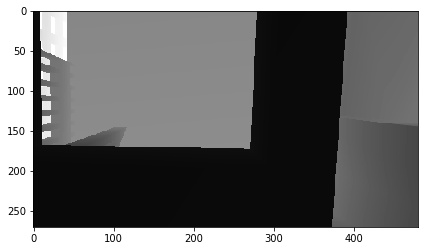

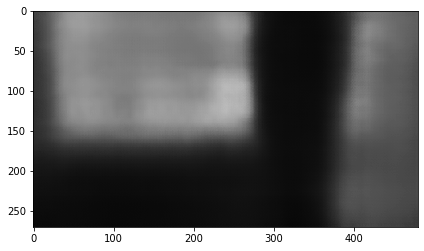

tensor(15696.3838, grad_fn=<SumBackward0>) tensor(40149.9023, grad_fn=<MseLossBackward0>)
tensor(17535.2402, grad_fn=<SubBackward0>)
Epoch: 40/250, Step: 55/55, Avg loss: 734.928, time: 238.13, Avg. per iter 4.37, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data115.tfrecords']
Iterating length... 	Done: 70
gotcha
tensor(15751.0664, grad_fn=<SumBackward0>) tensor(52387.1680, grad_fn=<MseLossBackward0>)
tensor(18497.9199, grad_fn=<SubBackward0>)
tensor(19063.8066, grad_fn=<SumBackward0>) tensor(69263.2500, grad_fn=<MseLossBackward0>)
tensor(21990.1387, grad_fn=<SubBackward0>)
tensor(15947.0059, grad_fn=<SumBackward0>) tensor(59558.0703, grad_fn=<MseLossBackward0>)
tensor(18498.3242, grad_fn=<SubBackward0>)
tensor(15145.7344, grad_fn=<SumBackward0>) tensor(49423.2617, grad_fn=<MseLossBackward0>)
tensor(17705.8574, grad_fn=<SubBackward0>)
tensor(16907.6367, grad_fn=<SumBackward0>) tensor(53494.9922, grad_fn=<MseLossBackward0>)
tensor(19414.6699, grad_fn=<SubBackw

tensor(19022.7969, grad_fn=<SumBackward0>) tensor(59460.7188, grad_fn=<MseLossBackward0>)
tensor(21387.6523, grad_fn=<SubBackward0>)
tensor(15787.1826, grad_fn=<SumBackward0>) tensor(49676.6992, grad_fn=<MseLossBackward0>)
tensor(18287.1523, grad_fn=<SubBackward0>)
tensor(16137.9082, grad_fn=<SumBackward0>) tensor(59290.0781, grad_fn=<MseLossBackward0>)
tensor(18606.1270, grad_fn=<SubBackward0>)
Epoch: 41/250, Step: 55/70, Avg loss: 630.485, time: 239.40, Avg. per iter 4.37, Est. time left 65.51

tensor(19927.1855, grad_fn=<SumBackward0>) tensor(74554.7344, grad_fn=<MseLossBackward0>)
tensor(22354.1602, grad_fn=<SubBackward0>)
tensor(18199.8320, grad_fn=<SumBackward0>) tensor(70716.6328, grad_fn=<MseLossBackward0>)
tensor(20552.1465, grad_fn=<SubBackward0>)
tensor(20024.5000, grad_fn=<SumBackward0>) tensor(58237.5078, grad_fn=<MseLossBackward0>)
tensor(22534.7266, grad_fn=<SubBackward0>)
tensor(16669.9668, grad_fn=<SumBackward0>) tensor(49491.6719, grad_fn=<MseLossBackward0>)
tensor(19

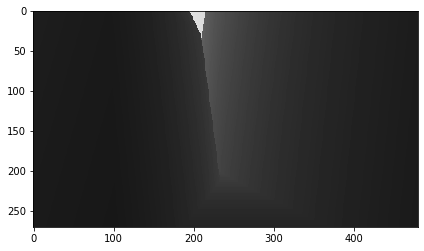

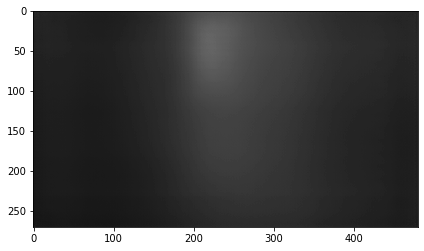

tensor(7815.7095, grad_fn=<SumBackward0>) tensor(20986.8887, grad_fn=<MseLossBackward0>)
tensor(9392.4521, grad_fn=<SubBackward0>)
Epoch: 41/250, Step: 70/70, Avg loss: 619.566, time: 300.73, Avg. per iter 4.37, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data16.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(24127.6797, grad_fn=<SumBackward0>) tensor(63591.8555, grad_fn=<MseLossBackward0>)
tensor(27433.6719, grad_fn=<SubBackward0>)
tensor(19173.5156, grad_fn=<SumBackward0>) tensor(57462.8906, grad_fn=<MseLossBackward0>)
tensor(22152.8711, grad_fn=<SubBackward0>)
tensor(15212.1338, grad_fn=<SumBackward0>) tensor(57710.1406, grad_fn=<MseLossBackward0>)
tensor(17929.3438, grad_fn=<SubBackward0>)
tensor(14964.9512, grad_fn=<SumBackward0>) tensor(48173.3398, grad_fn=<MseLossBackward0>)
tensor(17546.1230, grad_fn=<SubBackward0>)
tensor(22493.9902, grad_fn=<SumBackward0>) tensor(70297.7031, grad_fn=<MseLossBackward0>)
tensor(25131.5273, grad_fn=<SubBackward

tensor(15369.6875, grad_fn=<SumBackward0>) tensor(47046.8203, grad_fn=<MseLossBackward0>)
tensor(17726.3203, grad_fn=<SubBackward0>)
tensor(20527.8203, grad_fn=<SumBackward0>) tensor(72998.4531, grad_fn=<MseLossBackward0>)
tensor(23141.8477, grad_fn=<SubBackward0>)
tensor(20675.9062, grad_fn=<SumBackward0>) tensor(81225.2734, grad_fn=<MseLossBackward0>)
tensor(23129.2012, grad_fn=<SubBackward0>)
Epoch: 42/250, Step: 55/64, Avg loss: 653.014, time: 243.29, Avg. per iter 4.37, Est. time left 39.30

tensor(17118.3672, grad_fn=<SumBackward0>) tensor(60671.0039, grad_fn=<MseLossBackward0>)
tensor(19448.3965, grad_fn=<SubBackward0>)
tensor(19319.6992, grad_fn=<SumBackward0>) tensor(60842.9766, grad_fn=<MseLossBackward0>)
tensor(21925.7031, grad_fn=<SubBackward0>)
tensor(18743.7734, grad_fn=<SumBackward0>) tensor(47088.8281, grad_fn=<MseLossBackward0>)
tensor(21074.0371, grad_fn=<SubBackward0>)
tensor(17584.3418, grad_fn=<SumBackward0>) tensor(57050.9922, grad_fn=<MseLossBackward0>)
tensor(20

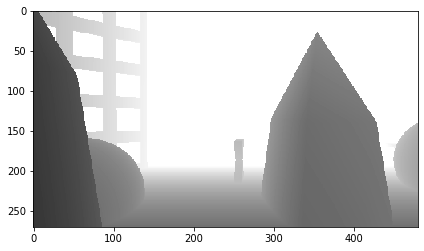

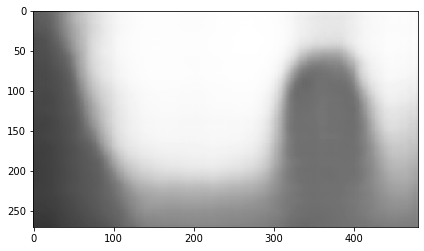

tensor(15028.4102, grad_fn=<SumBackward0>) tensor(45309.5703, grad_fn=<MseLossBackward0>)
tensor(17421.7148, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data131.tfrecords']
Iterating length... 	Done: 56
gotcha
tensor(22451.3008, grad_fn=<SumBackward0>) tensor(74613.9453, grad_fn=<MseLossBackward0>)
tensor(25093.8828, grad_fn=<SubBackward0>)
tensor(22832.6621, grad_fn=<SumBackward0>) tensor(74273.8750, grad_fn=<MseLossBackward0>)
tensor(25368.5898, grad_fn=<SubBackward0>)
tensor(21203.8691, grad_fn=<SumBackward0>) tensor(62547.7578, grad_fn=<MseLossBackward0>)
tensor(23586.3203, grad_fn=<SubBackward0>)
tensor(27568.6504, grad_fn=<SumBackward0>) tensor(75908.5312, grad_fn=<MseLossBackward0>)
tensor(29964.9121, grad_fn=<SubBackward0>)
tensor(18098.7559, grad_fn=<SumBackward0>) tensor(56281.0352, grad_fn=<MseLossBackward0>)
tensor(20661.5508, grad_fn=<SubBackward0>)
Epoch: 43/250, Step: 5/56, Avg loss: 779.220, time: 22.08, Avg. per iter 4.37, Est. time left 2

tensor(19232.5117, grad_fn=<SumBackward0>) tensor(63014.5117, grad_fn=<MseLossBackward0>)
tensor(21682.4824, grad_fn=<SubBackward0>)
tensor(18127.4609, grad_fn=<SumBackward0>) tensor(55816.3906, grad_fn=<MseLossBackward0>)
tensor(20634.8691, grad_fn=<SubBackward0>)
Epoch: 43/250, Step: 55/56, Avg loss: 718.417, time: 233.44, Avg. per iter 4.36, Est. time left 4.36



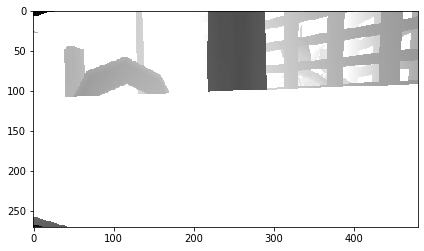

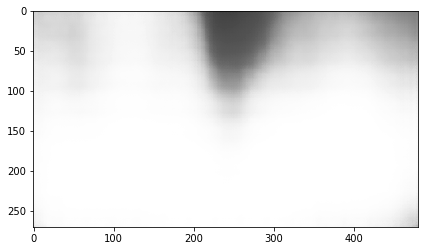

tensor(10721.7754, grad_fn=<SumBackward0>) tensor(34778.7031, grad_fn=<MseLossBackward0>)
tensor(12349.1494, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data33.tfrecords']
Iterating length... 	Done: 57
gotcha
tensor(20071.2422, grad_fn=<SumBackward0>) tensor(66134.6875, grad_fn=<MseLossBackward0>)
tensor(22586.7539, grad_fn=<SubBackward0>)
tensor(15065.6553, grad_fn=<SumBackward0>) tensor(51599.6680, grad_fn=<MseLossBackward0>)
tensor(17188.9082, grad_fn=<SubBackward0>)
tensor(19441.8184, grad_fn=<SumBackward0>) tensor(67155.2344, grad_fn=<MseLossBackward0>)
tensor(21860.4785, grad_fn=<SubBackward0>)
tensor(15169.2207, grad_fn=<SumBackward0>) tensor(51352.1875, grad_fn=<MseLossBackward0>)
tensor(17407.8184, grad_fn=<SubBackward0>)
tensor(14963.0859, grad_fn=<SumBackward0>) tensor(51673.6484, grad_fn=<MseLossBackward0>)
tensor(17503.2773, grad_fn=<SubBackward0>)
Epoch: 44/250, Step: 5/57, Avg loss: 603.420, time: 21.98, Avg. per iter 4.36, Est. time left 22

tensor(17638.3984, grad_fn=<SumBackward0>) tensor(57280.0430, grad_fn=<MseLossBackward0>)
tensor(20097.3242, grad_fn=<SubBackward0>)
tensor(14839.4619, grad_fn=<SumBackward0>) tensor(51971.5742, grad_fn=<MseLossBackward0>)
tensor(17109.2168, grad_fn=<SubBackward0>)
Epoch: 44/250, Step: 55/57, Avg loss: 626.398, time: 236.35, Avg. per iter 4.36, Est. time left 8.72

tensor(14450.2715, grad_fn=<SumBackward0>) tensor(48377.7148, grad_fn=<MseLossBackward0>)
tensor(16744.8008, grad_fn=<SubBackward0>)


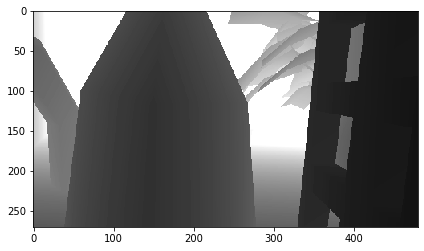

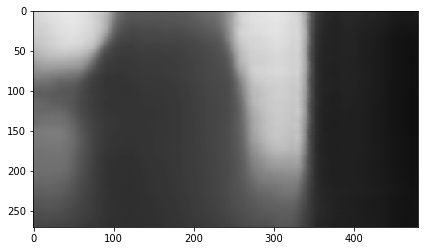

tensor(12464.2295, grad_fn=<SumBackward0>) tensor(36807.5898, grad_fn=<MseLossBackward0>)
tensor(14305.2227, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data118.tfrecords']
Iterating length... 	Done: 66
gotcha
tensor(20171.5195, grad_fn=<SumBackward0>) tensor(62334.3164, grad_fn=<MseLossBackward0>)
tensor(22769.8867, grad_fn=<SubBackward0>)
tensor(9112.2275, grad_fn=<SumBackward0>) tensor(32685.9570, grad_fn=<MseLossBackward0>)
tensor(11317.1875, grad_fn=<SubBackward0>)
tensor(15898.5322, grad_fn=<SumBackward0>) tensor(50625.0703, grad_fn=<MseLossBackward0>)
tensor(18288.3223, grad_fn=<SubBackward0>)
tensor(17830.2129, grad_fn=<SumBackward0>) tensor(61420.5078, grad_fn=<MseLossBackward0>)
tensor(20249.2012, grad_fn=<SubBackward0>)
tensor(12364.3438, grad_fn=<SumBackward0>) tensor(39411.4492, grad_fn=<MseLossBackward0>)
tensor(14734.4248, grad_fn=<SubBackward0>)
Epoch: 45/250, Step: 5/66, Avg loss: 545.994, time: 22.69, Avg. per iter 4.36, Est. time left 26

tensor(15322.2129, grad_fn=<SumBackward0>) tensor(43067.8281, grad_fn=<MseLossBackward0>)
tensor(17715.0430, grad_fn=<SubBackward0>)
tensor(15100.5557, grad_fn=<SumBackward0>) tensor(47338.4609, grad_fn=<MseLossBackward0>)
tensor(17550.8867, grad_fn=<SubBackward0>)
Epoch: 45/250, Step: 55/66, Avg loss: 557.373, time: 232.63, Avg. per iter 4.36, Est. time left 47.94

tensor(18483.1387, grad_fn=<SumBackward0>) tensor(53414.5078, grad_fn=<MseLossBackward0>)
tensor(21008.2051, grad_fn=<SubBackward0>)
tensor(13831.1465, grad_fn=<SumBackward0>) tensor(45913.1367, grad_fn=<MseLossBackward0>)
tensor(16226.9795, grad_fn=<SubBackward0>)
tensor(15750.9443, grad_fn=<SumBackward0>) tensor(51726.9766, grad_fn=<MseLossBackward0>)
tensor(18483.4316, grad_fn=<SubBackward0>)
tensor(15493.0059, grad_fn=<SumBackward0>) tensor(47328.1602, grad_fn=<MseLossBackward0>)
tensor(18067.3008, grad_fn=<SubBackward0>)
tensor(14469.1318, grad_fn=<SumBackward0>) tensor(47184.6992, grad_fn=<MseLossBackward0>)
tensor(17

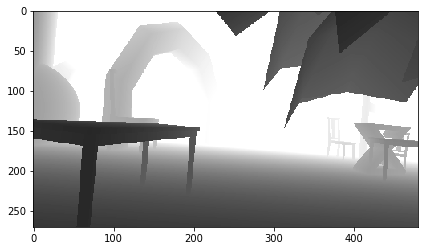

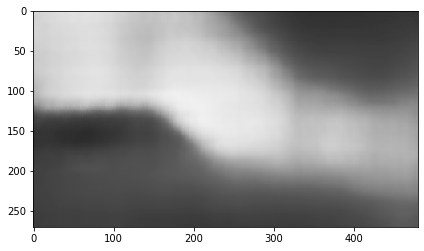

tensor(1563.4741, grad_fn=<SumBackward0>) tensor(5006.7539, grad_fn=<MseLossBackward0>)
tensor(1764.4495, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data14.tfrecords']
Iterating length... 	Done: 66
gotcha
tensor(15742.3936, grad_fn=<SumBackward0>) tensor(47262.6250, grad_fn=<MseLossBackward0>)
tensor(18081.2422, grad_fn=<SubBackward0>)
tensor(16120.2979, grad_fn=<SumBackward0>) tensor(49906.8281, grad_fn=<MseLossBackward0>)
tensor(18662.4121, grad_fn=<SubBackward0>)
tensor(17963.5781, grad_fn=<SumBackward0>) tensor(52747.7969, grad_fn=<MseLossBackward0>)
tensor(20198.5234, grad_fn=<SubBackward0>)
tensor(18497.9844, grad_fn=<SumBackward0>) tensor(54407.0859, grad_fn=<MseLossBackward0>)
tensor(20775.3770, grad_fn=<SubBackward0>)
tensor(18659.4121, grad_fn=<SumBackward0>) tensor(70130.1250, grad_fn=<MseLossBackward0>)
tensor(21057.0312, grad_fn=<SubBackward0>)
Epoch: 46/250, Step: 5/66, Avg loss: 617.341, time: 21.78, Avg. per iter 4.36, Est. time left 265.7

tensor(15144.1328, grad_fn=<SumBackward0>) tensor(48722.3203, grad_fn=<MseLossBackward0>)
tensor(17554.8594, grad_fn=<SubBackward0>)
tensor(14503.5859, grad_fn=<SumBackward0>) tensor(48786.8828, grad_fn=<MseLossBackward0>)
tensor(16895.5469, grad_fn=<SubBackward0>)
Epoch: 46/250, Step: 55/66, Avg loss: 615.900, time: 237.79, Avg. per iter 4.36, Est. time left 47.91

tensor(15625.3076, grad_fn=<SumBackward0>) tensor(54044.6172, grad_fn=<MseLossBackward0>)
tensor(18228.8613, grad_fn=<SubBackward0>)
tensor(21608.6484, grad_fn=<SumBackward0>) tensor(72321.2500, grad_fn=<MseLossBackward0>)
tensor(24237.5762, grad_fn=<SubBackward0>)
tensor(17199.9258, grad_fn=<SumBackward0>) tensor(48989.8008, grad_fn=<MseLossBackward0>)
tensor(19758.7012, grad_fn=<SubBackward0>)
tensor(15412.3008, grad_fn=<SumBackward0>) tensor(45266.8672, grad_fn=<MseLossBackward0>)
tensor(17937.8750, grad_fn=<SubBackward0>)
tensor(25834.1797, grad_fn=<SumBackward0>) tensor(91426.3438, grad_fn=<MseLossBackward0>)
tensor(28

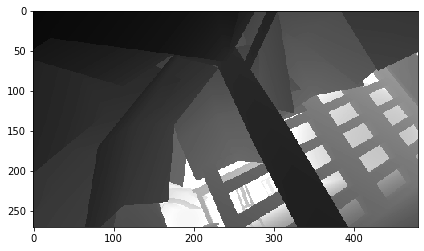

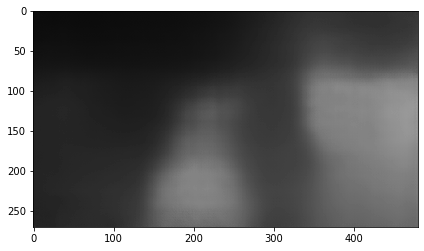

tensor(3264.4595, grad_fn=<SumBackward0>) tensor(12654.0488, grad_fn=<MseLossBackward0>)
tensor(3695.4009, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data61.tfrecords']
Iterating length... 	Done: 53
gotcha
tensor(17741.4805, grad_fn=<SumBackward0>) tensor(60414.2305, grad_fn=<MseLossBackward0>)
tensor(20121.1367, grad_fn=<SubBackward0>)
tensor(16127.9961, grad_fn=<SumBackward0>) tensor(54119.4922, grad_fn=<MseLossBackward0>)
tensor(18555.8398, grad_fn=<SubBackward0>)
tensor(20024.0117, grad_fn=<SumBackward0>) tensor(52500.2461, grad_fn=<MseLossBackward0>)
tensor(22382.2305, grad_fn=<SubBackward0>)
tensor(17161.8594, grad_fn=<SumBackward0>) tensor(50837.9883, grad_fn=<MseLossBackward0>)
tensor(19432.8398, grad_fn=<SubBackward0>)
tensor(17013.1719, grad_fn=<SumBackward0>) tensor(53990.5508, grad_fn=<MseLossBackward0>)
tensor(19420.4004, grad_fn=<SubBackward0>)
Epoch: 47/250, Step: 5/53, Avg loss: 624.453, time: 22.76, Avg. per iter 4.35, Est. time left 209.

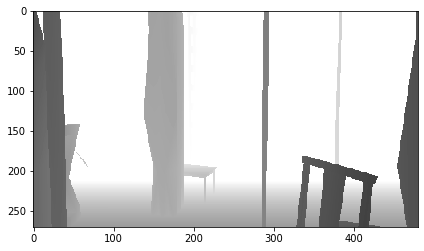

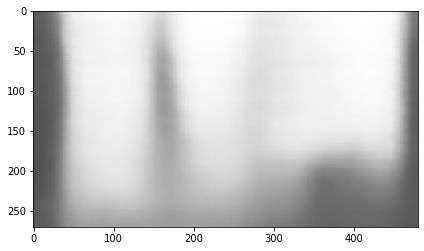

tensor(15639.7949, grad_fn=<SumBackward0>) tensor(53224.4453, grad_fn=<MseLossBackward0>)
tensor(17921.0645, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data146.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(19154.9180, grad_fn=<SumBackward0>) tensor(67346.2578, grad_fn=<MseLossBackward0>)
tensor(21654.0781, grad_fn=<SubBackward0>)
tensor(18697.3750, grad_fn=<SumBackward0>) tensor(64975.8672, grad_fn=<MseLossBackward0>)
tensor(21256.2695, grad_fn=<SubBackward0>)
tensor(24213.7539, grad_fn=<SumBackward0>) tensor(71846.9922, grad_fn=<MseLossBackward0>)
tensor(27010.3203, grad_fn=<SubBackward0>)
tensor(18349.2793, grad_fn=<SumBackward0>) tensor(52641.0312, grad_fn=<MseLossBackward0>)
tensor(20564.4102, grad_fn=<SubBackward0>)
tensor(23276.4238, grad_fn=<SumBackward0>) tensor(80819.3594, grad_fn=<MseLossBackward0>)
tensor(25779.9297, grad_fn=<SubBackward0>)
Epoch: 48/250, Step: 5/64, Avg loss: 726.656, time: 21.35, Avg. per iter 4.35, Est. time left 2

tensor(20783.0684, grad_fn=<SumBackward0>) tensor(74387.5703, grad_fn=<MseLossBackward0>)
tensor(23425.2363, grad_fn=<SubBackward0>)
tensor(17576.1016, grad_fn=<SumBackward0>) tensor(58167.8320, grad_fn=<MseLossBackward0>)
tensor(20051.7227, grad_fn=<SubBackward0>)
Epoch: 48/250, Step: 55/64, Avg loss: 708.414, time: 243.26, Avg. per iter 4.36, Est. time left 39.20

tensor(21678.3008, grad_fn=<SumBackward0>) tensor(70034.1797, grad_fn=<MseLossBackward0>)
tensor(24360.2852, grad_fn=<SubBackward0>)
tensor(18055.9688, grad_fn=<SumBackward0>) tensor(58260.1953, grad_fn=<MseLossBackward0>)
tensor(20607.1914, grad_fn=<SubBackward0>)
tensor(13749.3984, grad_fn=<SumBackward0>) tensor(42045.2422, grad_fn=<MseLossBackward0>)
tensor(16207.5977, grad_fn=<SubBackward0>)
tensor(18696.9355, grad_fn=<SumBackward0>) tensor(62362.4688, grad_fn=<MseLossBackward0>)
tensor(21382.8535, grad_fn=<SubBackward0>)
tensor(20544.8164, grad_fn=<SumBackward0>) tensor(75027.8828, grad_fn=<MseLossBackward0>)
tensor(23

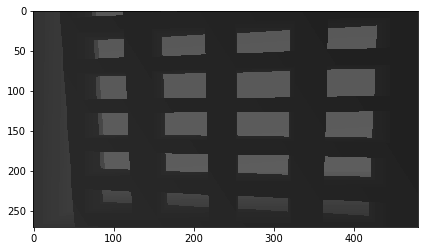

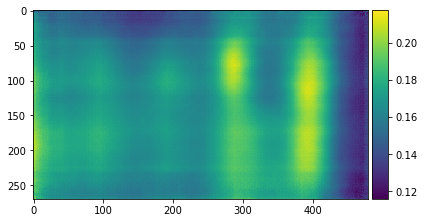

tensor(13331.6240, grad_fn=<SumBackward0>) tensor(46295.6406, grad_fn=<MseLossBackward0>)
tensor(14820.6973, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data46.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(15844.6943, grad_fn=<SumBackward0>) tensor(55289.5430, grad_fn=<MseLossBackward0>)
tensor(18130.8516, grad_fn=<SubBackward0>)
tensor(11916.0928, grad_fn=<SumBackward0>) tensor(37049.1719, grad_fn=<MseLossBackward0>)
tensor(14188.5791, grad_fn=<SubBackward0>)
tensor(16620.0312, grad_fn=<SumBackward0>) tensor(55886.4453, grad_fn=<MseLossBackward0>)
tensor(19049.9121, grad_fn=<SubBackward0>)
tensor(14876.5469, grad_fn=<SumBackward0>) tensor(48634.8242, grad_fn=<MseLossBackward0>)
tensor(17248.2012, grad_fn=<SubBackward0>)
tensor(17272.8301, grad_fn=<SumBackward0>) tensor(55757.6992, grad_fn=<MseLossBackward0>)
tensor(19947.1934, grad_fn=<SubBackward0>)
Epoch: 49/250, Step: 5/64, Avg loss: 553.530, time: 22.47, Avg. per iter 4.36, Est. time left 25

tensor(14499.4766, grad_fn=<SumBackward0>) tensor(50152.3477, grad_fn=<MseLossBackward0>)
tensor(17067.6348, grad_fn=<SubBackward0>)
tensor(19469.9473, grad_fn=<SumBackward0>) tensor(72698.4766, grad_fn=<MseLossBackward0>)
tensor(21934.2754, grad_fn=<SubBackward0>)
Epoch: 49/250, Step: 55/64, Avg loss: 596.427, time: 250.45, Avg. per iter 4.36, Est. time left 39.23

tensor(17290.0898, grad_fn=<SumBackward0>) tensor(55770.2578, grad_fn=<MseLossBackward0>)
tensor(19812.4062, grad_fn=<SubBackward0>)
tensor(14901.7275, grad_fn=<SumBackward0>) tensor(51066.7109, grad_fn=<MseLossBackward0>)
tensor(17355.1543, grad_fn=<SubBackward0>)
tensor(15992.4404, grad_fn=<SumBackward0>) tensor(52888.2930, grad_fn=<MseLossBackward0>)
tensor(18598.5078, grad_fn=<SubBackward0>)
tensor(16656.0352, grad_fn=<SumBackward0>) tensor(48626.2305, grad_fn=<MseLossBackward0>)
tensor(19235.0977, grad_fn=<SubBackward0>)
tensor(18931.0332, grad_fn=<SumBackward0>) tensor(67969.1484, grad_fn=<MseLossBackward0>)
tensor(21

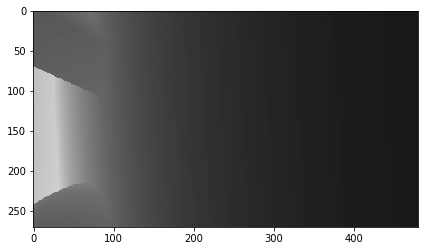

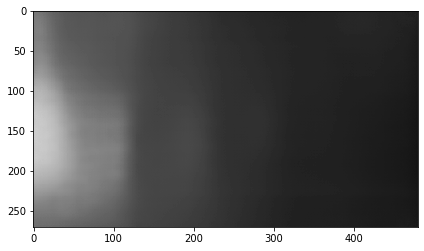

tensor(12613.4170, grad_fn=<SumBackward0>) tensor(45761.1797, grad_fn=<MseLossBackward0>)
tensor(14254.8379, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data38.tfrecords']
Iterating length... 	Done: 59
gotcha
tensor(22949.4258, grad_fn=<SumBackward0>) tensor(80082.6484, grad_fn=<MseLossBackward0>)
tensor(25520.1055, grad_fn=<SubBackward0>)
tensor(15662.4609, grad_fn=<SumBackward0>) tensor(51153.6211, grad_fn=<MseLossBackward0>)
tensor(18214.0273, grad_fn=<SubBackward0>)
tensor(16441.4043, grad_fn=<SumBackward0>) tensor(50929.9414, grad_fn=<MseLossBackward0>)
tensor(18938.7910, grad_fn=<SubBackward0>)
tensor(14722.9590, grad_fn=<SumBackward0>) tensor(44859.1641, grad_fn=<MseLossBackward0>)
tensor(17124.0059, grad_fn=<SubBackward0>)
tensor(16937.5762, grad_fn=<SumBackward0>) tensor(52491.7891, grad_fn=<MseLossBackward0>)
tensor(19455.6035, grad_fn=<SubBackward0>)
Epoch: 50/250, Step: 5/59, Avg loss: 620.328, time: 22.10, Avg. per iter 4.36, Est. time left 23

tensor(21062.9883, grad_fn=<SumBackward0>) tensor(71670.1875, grad_fn=<MseLossBackward0>)
tensor(23598.9941, grad_fn=<SubBackward0>)
tensor(20114.1660, grad_fn=<SumBackward0>) tensor(60182.2031, grad_fn=<MseLossBackward0>)
tensor(22691.7109, grad_fn=<SubBackward0>)
Epoch: 50/250, Step: 55/59, Avg loss: 626.425, time: 247.07, Avg. per iter 4.36, Est. time left 17.44

tensor(16170.9893, grad_fn=<SumBackward0>) tensor(58403.3945, grad_fn=<MseLossBackward0>)
tensor(18670.3730, grad_fn=<SubBackward0>)
tensor(16339.2363, grad_fn=<SumBackward0>) tensor(56507.8945, grad_fn=<MseLossBackward0>)
tensor(18800.3066, grad_fn=<SubBackward0>)
tensor(19456.8984, grad_fn=<SumBackward0>) tensor(57834.5469, grad_fn=<MseLossBackward0>)
tensor(21919.3477, grad_fn=<SubBackward0>)


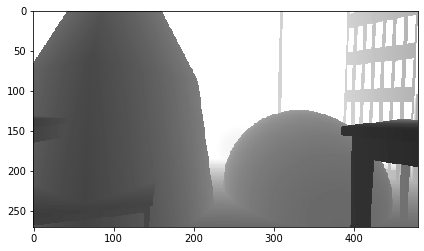

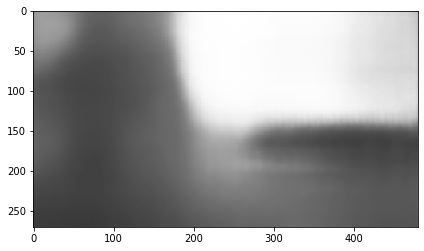

tensor(12496.4121, grad_fn=<SumBackward0>) tensor(38643.5000, grad_fn=<MseLossBackward0>)
tensor(14165.2607, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data44.tfrecords']
Iterating length... 	Done: 62
gotcha
tensor(14059.7637, grad_fn=<SumBackward0>) tensor(50047.8516, grad_fn=<MseLossBackward0>)
tensor(16389.0293, grad_fn=<SubBackward0>)
tensor(14702.0049, grad_fn=<SumBackward0>) tensor(46733.7422, grad_fn=<MseLossBackward0>)
tensor(16916.9727, grad_fn=<SubBackward0>)
tensor(12429.0771, grad_fn=<SumBackward0>) tensor(44680.3438, grad_fn=<MseLossBackward0>)
tensor(14676.7246, grad_fn=<SubBackward0>)
tensor(12362.7295, grad_fn=<SumBackward0>) tensor(42014.4570, grad_fn=<MseLossBackward0>)
tensor(14836.0938, grad_fn=<SubBackward0>)
tensor(12157.3867, grad_fn=<SumBackward0>) tensor(38749.4102, grad_fn=<MseLossBackward0>)
tensor(14424.9365, grad_fn=<SubBackward0>)
Epoch: 51/250, Step: 5/62, Avg loss: 482.773, time: 21.87, Avg. per iter 4.36, Est. time left 24

tensor(11502.6680, grad_fn=<SumBackward0>) tensor(37226.5156, grad_fn=<MseLossBackward0>)
tensor(14136.6680, grad_fn=<SubBackward0>)
tensor(18763.3770, grad_fn=<SumBackward0>) tensor(60151.0078, grad_fn=<MseLossBackward0>)
tensor(21288.9004, grad_fn=<SubBackward0>)
Epoch: 51/250, Step: 55/62, Avg loss: 555.767, time: 250.30, Avg. per iter 4.36, Est. time left 30.55

tensor(14050.5293, grad_fn=<SumBackward0>) tensor(50876.7344, grad_fn=<MseLossBackward0>)
tensor(16379.4121, grad_fn=<SubBackward0>)
tensor(14462.7549, grad_fn=<SumBackward0>) tensor(43654.8789, grad_fn=<MseLossBackward0>)
tensor(17089.0293, grad_fn=<SubBackward0>)
tensor(13819.9814, grad_fn=<SumBackward0>) tensor(47894.8242, grad_fn=<MseLossBackward0>)
tensor(16344.6758, grad_fn=<SubBackward0>)
tensor(13096.9746, grad_fn=<SumBackward0>) tensor(41085.2930, grad_fn=<MseLossBackward0>)
tensor(15410.1211, grad_fn=<SubBackward0>)
tensor(16320.3438, grad_fn=<SumBackward0>) tensor(47436.6602, grad_fn=<MseLossBackward0>)
tensor(18

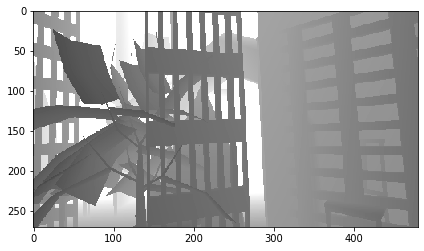

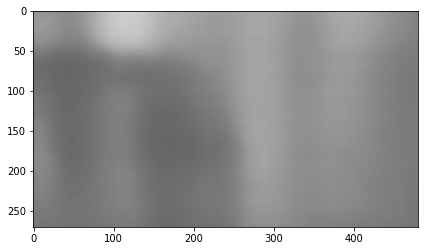

tensor(5531.2793, grad_fn=<SumBackward0>) tensor(15861.4404, grad_fn=<MseLossBackward0>)
tensor(6568.5713, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data172.tfrecords']
Iterating length... 	Done: 61
gotcha
tensor(17369.3438, grad_fn=<SumBackward0>) tensor(61117.7422, grad_fn=<MseLossBackward0>)
tensor(19785.6602, grad_fn=<SubBackward0>)
tensor(18569.0215, grad_fn=<SumBackward0>) tensor(61865.4609, grad_fn=<MseLossBackward0>)
tensor(21014.3398, grad_fn=<SubBackward0>)
tensor(20968.9414, grad_fn=<SumBackward0>) tensor(62665.2305, grad_fn=<MseLossBackward0>)
tensor(23528.9062, grad_fn=<SubBackward0>)
tensor(21437.2422, grad_fn=<SumBackward0>) tensor(64424.5273, grad_fn=<MseLossBackward0>)
tensor(24095.8848, grad_fn=<SubBackward0>)
tensor(18679.4492, grad_fn=<SumBackward0>) tensor(65492.2930, grad_fn=<MseLossBackward0>)
tensor(21282.4961, grad_fn=<SubBackward0>)
Epoch: 52/250, Step: 5/61, Avg loss: 685.671, time: 23.76, Avg. per iter 4.36, Est. time left 244

tensor(17660.8594, grad_fn=<SumBackward0>) tensor(60457.8359, grad_fn=<MseLossBackward0>)
tensor(20462.3438, grad_fn=<SubBackward0>)
tensor(13992.7266, grad_fn=<SumBackward0>) tensor(44403.4844, grad_fn=<MseLossBackward0>)
tensor(16775.3652, grad_fn=<SubBackward0>)
Epoch: 52/250, Step: 55/61, Avg loss: 642.309, time: 257.75, Avg. per iter 4.37, Est. time left 26.21

tensor(16795.4277, grad_fn=<SumBackward0>) tensor(53755.6562, grad_fn=<MseLossBackward0>)
tensor(19586.9062, grad_fn=<SubBackward0>)
tensor(13852.1250, grad_fn=<SumBackward0>) tensor(47144.2617, grad_fn=<MseLossBackward0>)
tensor(16390.7578, grad_fn=<SubBackward0>)
tensor(16021.2480, grad_fn=<SumBackward0>) tensor(55938.2109, grad_fn=<MseLossBackward0>)
tensor(18535.2969, grad_fn=<SubBackward0>)
tensor(22417.5195, grad_fn=<SumBackward0>) tensor(73747.9062, grad_fn=<MseLossBackward0>)
tensor(24757.5195, grad_fn=<SubBackward0>)
tensor(22933.3164, grad_fn=<SumBackward0>) tensor(82930.5000, grad_fn=<MseLossBackward0>)
tensor(25

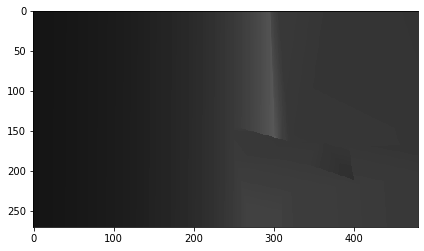

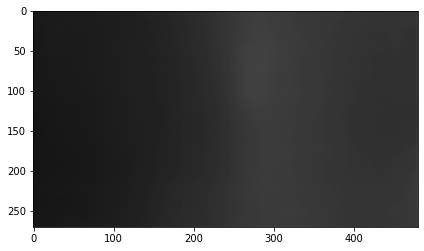

tensor(938.2015, grad_fn=<SumBackward0>) tensor(2266.2983, grad_fn=<MseLossBackward0>)
tensor(1066.6572, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data103.tfrecords']
Iterating length... 	Done: 65
gotcha
tensor(22342.3145, grad_fn=<SumBackward0>) tensor(63937.9727, grad_fn=<MseLossBackward0>)
tensor(24852.3906, grad_fn=<SubBackward0>)
tensor(20915.4961, grad_fn=<SumBackward0>) tensor(69068.4922, grad_fn=<MseLossBackward0>)
tensor(23332.8887, grad_fn=<SubBackward0>)
tensor(21045.4883, grad_fn=<SumBackward0>) tensor(76663.7344, grad_fn=<MseLossBackward0>)
tensor(23512.3398, grad_fn=<SubBackward0>)
tensor(19252.6836, grad_fn=<SumBackward0>) tensor(66424.5625, grad_fn=<MseLossBackward0>)
tensor(21781.5820, grad_fn=<SubBackward0>)
tensor(20580.8730, grad_fn=<SumBackward0>) tensor(73035.2734, grad_fn=<MseLossBackward0>)
tensor(23121.8809, grad_fn=<SubBackward0>)
Epoch: 53/250, Step: 5/65, Avg loss: 728.757, time: 22.91, Avg. per iter 4.37, Est. time left 262.1

tensor(22096.7539, grad_fn=<SumBackward0>) tensor(79791.3438, grad_fn=<MseLossBackward0>)
tensor(24646.4648, grad_fn=<SubBackward0>)
tensor(19078.1387, grad_fn=<SumBackward0>) tensor(61591.2891, grad_fn=<MseLossBackward0>)
tensor(21584.5762, grad_fn=<SubBackward0>)
Epoch: 53/250, Step: 55/65, Avg loss: 665.203, time: 247.37, Avg. per iter 4.37, Est. time left 43.70

tensor(20365.8652, grad_fn=<SumBackward0>) tensor(63927.9766, grad_fn=<MseLossBackward0>)
tensor(22691.8164, grad_fn=<SubBackward0>)
tensor(24609.7617, grad_fn=<SumBackward0>) tensor(69809.1719, grad_fn=<MseLossBackward0>)
tensor(27083.9941, grad_fn=<SubBackward0>)
tensor(18858.0898, grad_fn=<SumBackward0>) tensor(61074.7031, grad_fn=<MseLossBackward0>)
tensor(21100.0703, grad_fn=<SubBackward0>)
tensor(24500.7969, grad_fn=<SumBackward0>) tensor(90110.8906, grad_fn=<MseLossBackward0>)
tensor(26973.2559, grad_fn=<SubBackward0>)
tensor(22337.4805, grad_fn=<SumBackward0>) tensor(82836.8906, grad_fn=<MseLossBackward0>)
tensor(24

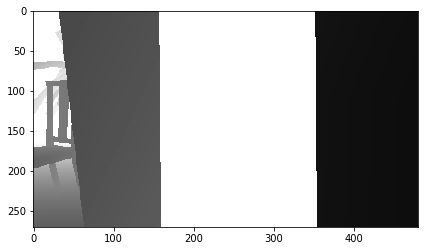

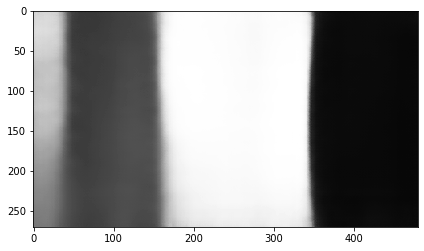

tensor(1007.1652, grad_fn=<SumBackward0>) tensor(4399.0415, grad_fn=<MseLossBackward0>)
tensor(1237.0022, grad_fn=<SubBackward0>)
Epoch: 53/250, Step: 65/65, Avg loss: 665.407, time: 288.28, Avg. per iter 4.37, Est. time left 0.00

Loading tfrecords... 	['../../../rl_data/tfrecord/data131.tfrecords']
Iterating length... 	Done: 56
gotcha
tensor(15327.9863, grad_fn=<SumBackward0>) tensor(51294.1953, grad_fn=<MseLossBackward0>)
tensor(18174.4492, grad_fn=<SubBackward0>)
tensor(21995.0801, grad_fn=<SumBackward0>) tensor(58465.8047, grad_fn=<MseLossBackward0>)
tensor(24839.0312, grad_fn=<SubBackward0>)
tensor(15912.0020, grad_fn=<SumBackward0>) tensor(51101.7500, grad_fn=<MseLossBackward0>)
tensor(18547.3809, grad_fn=<SubBackward0>)
tensor(18328.3633, grad_fn=<SumBackward0>) tensor(62245.8203, grad_fn=<MseLossBackward0>)
tensor(20882.9277, grad_fn=<SubBackward0>)
tensor(16106.7129, grad_fn=<SumBackward0>) tensor(52531.3086, grad_fn=<MseLossBackward0>)
tensor(18344.7148, grad_fn=<SubBackward

tensor(17942.7715, grad_fn=<SumBackward0>) tensor(57361.2422, grad_fn=<MseLossBackward0>)
tensor(20562.3203, grad_fn=<SubBackward0>)
tensor(14586.6016, grad_fn=<SumBackward0>) tensor(45468.7930, grad_fn=<MseLossBackward0>)
tensor(17211.4141, grad_fn=<SubBackward0>)
tensor(17753.4668, grad_fn=<SumBackward0>) tensor(56723.1328, grad_fn=<MseLossBackward0>)
tensor(20466.2734, grad_fn=<SubBackward0>)
Epoch: 54/250, Step: 55/56, Avg loss: 641.750, time: 254.67, Avg. per iter 4.37, Est. time left 4.37



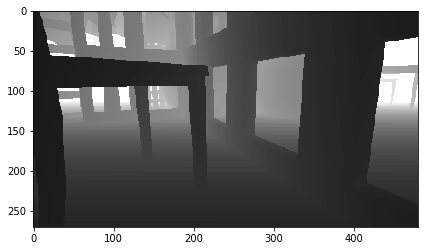

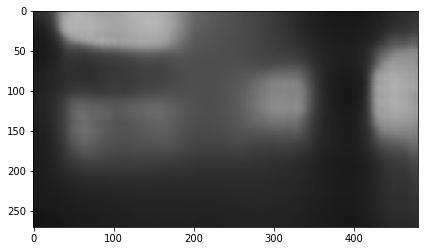

tensor(11699.0264, grad_fn=<SumBackward0>) tensor(37380.2461, grad_fn=<MseLossBackward0>)
tensor(13257.6787, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data22.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(16063.0098, grad_fn=<SumBackward0>) tensor(57761.5977, grad_fn=<MseLossBackward0>)
tensor(18306.3711, grad_fn=<SubBackward0>)
tensor(13791.1816, grad_fn=<SumBackward0>) tensor(48130.3828, grad_fn=<MseLossBackward0>)
tensor(16034.8867, grad_fn=<SubBackward0>)
tensor(13802.4229, grad_fn=<SumBackward0>) tensor(40519.5742, grad_fn=<MseLossBackward0>)
tensor(16105.3145, grad_fn=<SubBackward0>)
tensor(13065.9883, grad_fn=<SumBackward0>) tensor(38903.1016, grad_fn=<MseLossBackward0>)
tensor(15343.8320, grad_fn=<SubBackward0>)
tensor(14573.4297, grad_fn=<SumBackward0>) tensor(47441.1523, grad_fn=<MseLossBackward0>)
tensor(16966.7969, grad_fn=<SubBackward0>)
Epoch: 55/250, Step: 5/64, Avg loss: 517.233, time: 21.49, Avg. per iter 4.37, Est. time left 25

tensor(18920.2715, grad_fn=<SumBackward0>) tensor(60740.2109, grad_fn=<MseLossBackward0>)
tensor(21603.0977, grad_fn=<SubBackward0>)
tensor(20470.0078, grad_fn=<SumBackward0>) tensor(62230.2773, grad_fn=<MseLossBackward0>)
tensor(23342.1445, grad_fn=<SubBackward0>)
Epoch: 55/250, Step: 55/64, Avg loss: 599.180, time: 250.62, Avg. per iter 4.38, Est. time left 39.38

tensor(17421.7461, grad_fn=<SumBackward0>) tensor(58944.1289, grad_fn=<MseLossBackward0>)
tensor(19736.8262, grad_fn=<SubBackward0>)
tensor(18242.8301, grad_fn=<SumBackward0>) tensor(67571.7734, grad_fn=<MseLossBackward0>)
tensor(20521.5117, grad_fn=<SubBackward0>)
tensor(21299.1250, grad_fn=<SumBackward0>) tensor(64573.2266, grad_fn=<MseLossBackward0>)
tensor(23857.3770, grad_fn=<SubBackward0>)
tensor(14311.9287, grad_fn=<SumBackward0>) tensor(41384.2539, grad_fn=<MseLossBackward0>)
tensor(16756.4375, grad_fn=<SubBackward0>)
tensor(15012.5410, grad_fn=<SumBackward0>) tensor(52791.1797, grad_fn=<MseLossBackward0>)
tensor(17

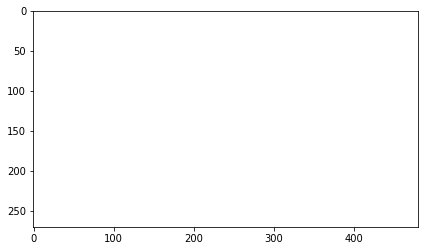

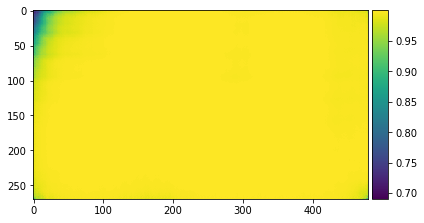

tensor(7450.6890, grad_fn=<SumBackward0>) tensor(27965.2344, grad_fn=<MseLossBackward0>)
tensor(8619.5537, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data164.tfrecords']
Iterating length... 	Done: 63
gotcha
tensor(12392.6494, grad_fn=<SumBackward0>) tensor(42755.1562, grad_fn=<MseLossBackward0>)
tensor(14551.7832, grad_fn=<SubBackward0>)
tensor(10523.1504, grad_fn=<SumBackward0>) tensor(34912.0586, grad_fn=<MseLossBackward0>)
tensor(12927.3184, grad_fn=<SubBackward0>)
tensor(17003.3730, grad_fn=<SumBackward0>) tensor(54570.8867, grad_fn=<MseLossBackward0>)
tensor(19522.7695, grad_fn=<SubBackward0>)
tensor(14127.9463, grad_fn=<SumBackward0>) tensor(50053.8086, grad_fn=<MseLossBackward0>)
tensor(16533.2383, grad_fn=<SubBackward0>)
tensor(15775.5703, grad_fn=<SumBackward0>) tensor(54062.1055, grad_fn=<MseLossBackward0>)
tensor(18199.8984, grad_fn=<SubBackward0>)
Epoch: 56/250, Step: 5/63, Avg loss: 510.844, time: 23.57, Avg. per iter 4.38, Est. time left 253

tensor(15419.2148, grad_fn=<SumBackward0>) tensor(53695.0469, grad_fn=<MseLossBackward0>)
tensor(17858.9688, grad_fn=<SubBackward0>)
tensor(19690.1367, grad_fn=<SumBackward0>) tensor(64732.4922, grad_fn=<MseLossBackward0>)
tensor(22357.3828, grad_fn=<SubBackward0>)
Epoch: 56/250, Step: 55/63, Avg loss: 577.623, time: 248.28, Avg. per iter 4.38, Est. time left 35.02

tensor(17865.7324, grad_fn=<SumBackward0>) tensor(54114.1836, grad_fn=<MseLossBackward0>)
tensor(20695.3828, grad_fn=<SubBackward0>)
tensor(16773.1328, grad_fn=<SumBackward0>) tensor(59546.3125, grad_fn=<MseLossBackward0>)
tensor(19447.7246, grad_fn=<SubBackward0>)
tensor(13433.7266, grad_fn=<SumBackward0>) tensor(46202.7852, grad_fn=<MseLossBackward0>)
tensor(15731.1953, grad_fn=<SubBackward0>)
tensor(21861.2773, grad_fn=<SumBackward0>) tensor(76782.9688, grad_fn=<MseLossBackward0>)
tensor(24270.2754, grad_fn=<SubBackward0>)
tensor(15114.9902, grad_fn=<SumBackward0>) tensor(49620.1094, grad_fn=<MseLossBackward0>)
tensor(17

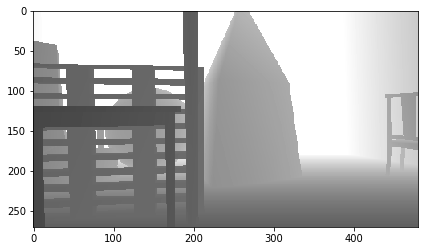

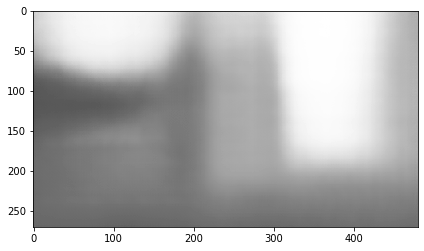

tensor(4352.9053, grad_fn=<SumBackward0>) tensor(14943.6973, grad_fn=<MseLossBackward0>)
tensor(4827.9380, grad_fn=<SubBackward0>)
Loading tfrecords... 	['../../../rl_data/tfrecord/data105.tfrecords']
Iterating length... 	Done: 64
gotcha
tensor(18841.9707, grad_fn=<SumBackward0>) tensor(68402.2891, grad_fn=<MseLossBackward0>)
tensor(21273.7520, grad_fn=<SubBackward0>)
tensor(22372.1816, grad_fn=<SumBackward0>) tensor(73993.2969, grad_fn=<MseLossBackward0>)
tensor(24841.5469, grad_fn=<SubBackward0>)
tensor(17555.8027, grad_fn=<SumBackward0>) tensor(52558.7930, grad_fn=<MseLossBackward0>)
tensor(20040.4199, grad_fn=<SubBackward0>)
tensor(15481.3037, grad_fn=<SumBackward0>) tensor(47747.6172, grad_fn=<MseLossBackward0>)
tensor(18091.1992, grad_fn=<SubBackward0>)
tensor(18066.8789, grad_fn=<SumBackward0>) tensor(62007.5625, grad_fn=<MseLossBackward0>)
tensor(20554.0117, grad_fn=<SubBackward0>)
Epoch: 57/250, Step: 5/64, Avg loss: 655.006, time: 21.99, Avg. per iter 4.38, Est. time left 258

In [ ]:
time_iteration = []
# train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# train_loader = next(iter(train_loader))

save_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid_MSE_weighted"
load_model_file = "/home/patricknit/vae_models/vae_dronet_sigmoid.pth"

for epoch in range(num_epochs):
    overall_loss = 0
    overall_elbo = 0
    since = time.time()
    
    # Random file each time
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    n_iterations = len(train_loader)
    
    for i, (image, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = weighted_MSE(image, x_hat, mu, logvar)
        print(loss)

        overall_loss += loss

        # Update weights
        
        loss.backward()
        optimiser.step()
        
        
        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
            print()
            
        if (i+1) % (n_iterations-1) == 0:
            imshow(image[0])
            imshow(x_hat[0].detach())
    
    save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
    torch.save(vae_model.state_dict(), save_model_file_dir)
            

# Some results

### BCE
- 10 epochs, no batch norm: 60191.195

### BCE with unpooling
- 10 epochs, clear reconstruction but image indices carried through VAE. Faster training than BCE

### ReLU + MSE loss
- Avg loss: 2629.289, very poor reconstruction

In [ ]:
# torch.save(vae_model.state_dict(), save_model_file)

In [ ]:
# load_model=True
# if load_model:
#     vae_model.load_state_dict(torch.load("../../../vae_models/vae_dronet_sigmoid_BCE_riga_924.pth"))
#     vae_model.eval()
# else:
#     vae_model.train()

# Training Run 2

In [ ]:
# vae_model = VAE(n_z=latent_dim)

# if load_model:
#     vae_model.load_state_dict(torch.load(load_model_file))
#     vae_model.eval()
# else:
#     vae_model.train()

# optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
# summary(vae_model, (1, 270, 480))

In [ ]:
# time_iteration = []
# # train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# # train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# # train_loader = next(iter(train_loader))

# for epoch in range(150):
#     overall_loss = 0
#     overall_elbo = 0
#     since = time.time()
    
#     train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
#     n_iterations = len(train_loader)
    
#     for i, (image, *_) in enumerate(train_loader):
#         since_iter = time.time()

#         optimiser.zero_grad()

#         # VAE forward pass
#         x_hat, mu, logvar, z = vae_model(image)

#         # Loss
#         loss = mse_loss(image, x_hat, mu, logvar)

#         overall_loss += loss

#         # Update weights
        
#         loss.backward()
#         optimiser.step()
        
        
#         time_iteration.append(time.time() - since_iter)
#         iter_time_mean = np.array(time_iteration).mean()
        
#         if (i+1) % 5 == 0:
#             time_elapsed = time.time() - since
#             print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
#             print()
#             save_model_file = f"../../../vae_models/vae_resnet_drone_net_mse_{i+1}.pth"
#             torch.save(vae_model.state_dict(), save_model_file)
            
#         if (i+1) % 50 == 0:
#             imshow(image[0])
#             imshow(x_hat[0].detach())
#             '

# Evaluation

In [ ]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    
    images, *_ = next(iter(test_loader))

    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()
# Visualise sample of images

with torch.no_grad():
        
    images, *_ = next(iter(train_loader)) # if dataset is shuffled every iter(), essentially test 
    # VAE forward pass
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])
